# Problem Statement
- Rossmann is a European drug distributor which operates over 3,000 drug stores across seven European countries. Since a lot of drugs come with a short shelf life, that is, they do not have a long expiry date, it becomes imperative for Rossmann to accurately forecast sales at their individual stores. As expected, store sales are influenced by many factors, including promotional campaigns, competition, state holidays, seasonality, and locality.The company needs the forecast daily sales for the next six weeks.Since the company is just embarking on this project, the scope has been kept to nine key stores across Europe. The stores are key for the company keeping in mind the revenue and historical prestige associated with them. These stores are numbered - 1,3,8,9,13,25,29,31 and 46.

# Data Definition

The store table contains the metadata for every single store including the following:
- **Store** - an Id that represents the store
- **StoreType** - differentiates between 4 different store models: a, b, c, d
- **Assortment** - describes an assortment level: a = basic, b = extra, c = extended
- **CompetitionDistance** - describes thedistance in meters to the nearest competitor store
- **CompetitionOpenSince**[Month/Year] - gives the approximate year and month of the time the nearest competitor was opened
- **Promo2** - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
- **Promo2Since**[Year/Week] - describes the year and calendar week when the store started participating in Promo2
- **PromoInterval** - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb, May, Aug, Nov" means each round starts in February, May, August, November of any given year for that store

The train table contains the sales data for individual stores at a daily level along with the details about the day
- **Store** - a unique Id for each store
- **DayOfWeek** - Describes the day of the week (1 - Monday till 7 - Sunday)
- **Date** - Describes the date on the day
- **Sales** - the turnover for any given day (this is what you are forecasting)
- **Customers** - the number of customers on a given day
- **Open** - an indicator for whether the store was open: 0 = closed, 1 = open
- **StateHoliday** - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None
- **SchoolHoliday** - indicates if the (Store, Date) was affected by the closure of public schools

In [1]:
# Import the necessary libraries
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm
from pylab import rcParams
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.stattools import adfuller, kpss,acf,pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error
from statsmodels.tsa import arima_model
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [2]:
store = pd.read_csv('store.csv')
store.head(20)

Store StoreType Assortment  CompetitionDistance  \
0       1         c          a               1270.0   
1       2         a          a                570.0   
2       3         a          a              14130.0   
3       4         c          c                620.0   
4       5         a          a              29910.0   
5       6         a          a                310.0   
6       7         a          c              24000.0   
7       8         a          a               7520.0   
8       9         a          c               2030.0   
9      10         a          a               3160.0   
10     11         a          c                960.0   
11     12         a          c               1070.0   
12     13         d          a                310.0   
13     14         a          a               1300.0   
14     15         d          c               4110.0   
15     16         a          c               3270.0   
16     17         a          a                 50.0   
17     18         d          c              13840.0   
18     19         a          c               3240.0   
19     20         d          a               2340.0   

    CompetitionOpenSinceMonth  CompetitionOpenSinceYear  Promo2  \
0                         9.0                    2008.0       0   
1                        11.0                    2007.0       1   
2                        12.0                    2006.0       1   
3                         9.0                    2009.0       0   
4                         4.0                    2015.0       0   
5                        12.0                    2013.0       0   
6                         4.0                    2013.0       0   
7                        10.0                    2014.0       0   
8                         8.0                    2000.0       0   
9                         9.0                    2009.0       0   
10                       11.0                    2011.0       1   
11                        NaN                       NaN       1   
12                        NaN                       NaN       1   
13                        3.0                    2014.0       1   
14                        3.0                    2010.0       1   
15                        NaN                       NaN       0   
16                       12.0                    2005.0       1   
17                        6.0                    2010.0       1   
18                        NaN                       NaN       1   
19                        5.0                    2009.0       1   

    Promo2SinceWeek  Promo2SinceYear     PromoInterval  
0               NaN              NaN               NaN  
1              13.0           2010.0   Jan,Apr,Jul,Oct  
2              14.0           2011.0   Jan,Apr,Jul,Oct  
3               NaN              NaN               NaN  
4               NaN              NaN               NaN  
5               NaN              NaN               NaN  
6               NaN              NaN               NaN  
7               NaN              NaN               NaN  
8               NaN              NaN               NaN  
9               NaN              NaN               NaN  
10              1.0           2012.0   Jan,Apr,Jul,Oct  
11             13.0           2010.0   Jan,Apr,Jul,Oct  
12             45.0           2009.0   Feb,May,Aug,Nov  
13             40.0           2011.0   Jan,Apr,Jul,Oct  
14             14.0           2011.0   Jan,Apr,Jul,Oct  
15              NaN              NaN               NaN  
16             26.0           2010.0   Jan,Apr,Jul,Oct  
17             14.0           2012.0   Jan,Apr,Jul,Oct  
18             22.0           2011.0  Mar,Jun,Sept,Dec  
19             40.0           2014.0   Jan,Apr,Jul,Oct

In [3]:
#train = pd.read_csv('train.csv', parse_dates = True, index_col = 'Date')
train = pd.read_csv('train.csv')
train['Date'] = pd.to_datetime(train['Date'])
train.head(20)

Store  DayOfWeek       Date  Sales  Customers  Open  Promo StateHoliday  \
0       1          5 2015-07-31   5263        555     1      1            0   
1       2          5 2015-07-31   6064        625     1      1            0   
2       3          5 2015-07-31   8314        821     1      1            0   
3       4          5 2015-07-31  13995       1498     1      1            0   
4       5          5 2015-07-31   4822        559     1      1            0   
5       6          5 2015-07-31   5651        589     1      1            0   
6       7          5 2015-07-31  15344       1414     1      1            0   
7       8          5 2015-07-31   8492        833     1      1            0   
8       9          5 2015-07-31   8565        687     1      1            0   
9      10          5 2015-07-31   7185        681     1      1            0   
10     11          5 2015-07-31  10457       1236     1      1            0   
11     12          5 2015-07-31   8959        962     1      1            0   
12     13          5 2015-07-31   8821        568     1      1            0   
13     14          5 2015-07-31   6544        710     1      1            0   
14     15          5 2015-07-31   9191        766     1      1            0   
15     16          5 2015-07-31  10231        979     1      1            0   
16     17          5 2015-07-31   8430        946     1      1            0   
17     18          5 2015-07-31  10071        936     1      1            0   
18     19          5 2015-07-31   8234        718     1      1            0   
19     20          5 2015-07-31   9593        974     1      1            0   

    SchoolHoliday  
0               1  
1               1  
2               1  
3               1  
4               1  
5               1  
6               1  
7               1  
8               1  
9               1  
10              1  
11              1  
12              0  
13              1  
14              1  
15              1  
16              1  
17              1  
18              1  
19              0

In [4]:
#Merge the store and train data on the Store column
train_store = pd.merge(train,store,on = 'Store')
train_store.head(20)

Store  DayOfWeek       Date  Sales  Customers  Open  Promo StateHoliday  \
0       1          5 2015-07-31   5263        555     1      1            0   
1       1          4 2015-07-30   5020        546     1      1            0   
2       1          3 2015-07-29   4782        523     1      1            0   
3       1          2 2015-07-28   5011        560     1      1            0   
4       1          1 2015-07-27   6102        612     1      1            0   
5       1          7 2015-07-26      0          0     0      0            0   
6       1          6 2015-07-25   4364        500     1      0            0   
7       1          5 2015-07-24   3706        459     1      0            0   
8       1          4 2015-07-23   3769        503     1      0            0   
9       1          3 2015-07-22   3464        463     1      0            0   
10      1          2 2015-07-21   3558        469     1      0            0   
11      1          1 2015-07-20   4395        526     1      0            0   
12      1          7 2015-07-19      0          0     0      0            0   
13      1          6 2015-07-18   4406        512     1      0            0   
14      1          5 2015-07-17   4852        519     1      1            0   
15      1          4 2015-07-16   4427        517     1      1            0   
16      1          3 2015-07-15   4767        550     1      1            0   
17      1          2 2015-07-14   5042        544     1      1            0   
18      1          1 2015-07-13   5054        553     1      1            0   
19      1          7 2015-07-12      0          0     0      0            0   

    SchoolHoliday StoreType Assortment  CompetitionDistance  \
0               1         c          a               1270.0   
1               1         c          a               1270.0   
2               1         c          a               1270.0   
3               1         c          a               1270.0   
4               1         c          a               1270.0   
5               0         c          a               1270.0   
6               0         c          a               1270.0   
7               0         c          a               1270.0   
8               0         c          a               1270.0   
9               0         c          a               1270.0   
10              0         c          a               1270.0   
11              0         c          a               1270.0   
12              0         c          a               1270.0   
13              0         c          a               1270.0   
14              0         c          a               1270.0   
15              0         c          a               1270.0   
16              0         c          a               1270.0   
17              0         c          a               1270.0   
18              0         c          a               1270.0   
19              0         c          a               1270.0   

    CompetitionOpenSinceMonth  CompetitionOpenSinceYear  Promo2  \
0                         9.0                    2008.0       0   
1                         9.0                    2008.0       0   
2                         9.0                    2008.0       0   
3                         9.0                    2008.0       0   
4                         9.0                    2008.0       0   
5                         9.0                    2008.0       0   
6                         9.0                    2008.0       0   
7                         9.0                    2008.0       0   
8                         9.0                    2008.0       0   
9                         9.0                    2008.0       0   
10                        9.0                    2008.0       0   
11                        9.0                    2008.0       0   
12                        9.0                    2008.0       0   
13                        9.0                    2008.0       0   
14             

In [5]:
train_store.tail()

Store  DayOfWeek       Date  Sales  Customers  Open  Promo  \
1017204   1115          6 2013-01-05   4771        339     1      0   
1017205   1115          5 2013-01-04   4540        326     1      0   
1017206   1115          4 2013-01-03   4297        300     1      0   
1017207   1115          3 2013-01-02   3697        305     1      0   
1017208   1115          2 2013-01-01      0          0     0      0   

        StateHoliday  SchoolHoliday StoreType Assortment  CompetitionDistance  \
1017204            0              1         d          c               5350.0   
1017205            0              1         d          c               5350.0   
1017206            0              1         d          c               5350.0   
1017207            0              1         d          c               5350.0   
1017208            a              1         d          c               5350.0   

         CompetitionOpenSinceMonth  CompetitionOpenSinceYear  Promo2  \
1017204                        NaN                       NaN       1   
1017205                        NaN                       NaN       1   
1017206                        NaN                       NaN       1   
1017207                        NaN                       NaN       1   
1017208                        NaN                       NaN       1   

         Promo2SinceWeek  Promo2SinceYear     PromoInterval  
1017204             22.0           2012.0  Mar,Jun,Sept,Dec  
1017205             22.0           2012.0  Mar,Jun,Sept,Dec  
1017206             22.0           2012.0  Mar,Jun,Sept,Dec  
1017207             22.0           2012.0  Mar,Jun,Sept,Dec  
1017208             22.0           2012.0  Mar,Jun,Sept,Dec

In [6]:
#Storetype with various assortments
def StypeXAssortment(df):
    StoretypeAssortment = sns.countplot(x = 'StoreType', hue = 'Assortment', order = ['a','b','c','d'], data = train_store, 
              palette = sns.color_palette("Set1", n_colors = 3)).set_title('StoretypeXAssortment')
    plt.show()
    return

In [7]:
#Impact of Promo on Sales and Customers
train_store['Month'] = pd.DatetimeIndex(train_store['Date']).month #Lets derive month to check the sales month wise
def promoSales(df):
    print('Monthly Sales with and Without Promo')
    sns.factorplot(data = df, x = 'Month', y = 'Sales',
               col = 'StoreType',
               pallete = 'plasma',
               hue = 'StoreType',
               row = 'Promo')
    plt.show()
    
    print('Monthly Customers with and Without Promo')
    sns.factorplot(data = df, x = 'Month', y = 'Customers',
               col = 'StoreType',
               pallete = 'plasma',
               hue = 'StoreType',
               row = 'Promo')
    plt.show()

    return

In [8]:
##Impact of Promo2 on Sales and Customers
def promo2Sales(df):
    print('Monthly Sales with and Without Promo')
    sns.factorplot(data = df, x = 'Month', y = 'Sales',
               col = 'StoreType',
               pallete = 'plasma',
               hue = 'StoreType',
               row = 'Promo2')
    plt.show()
    
    print('Monthly Customers with and Without Promo')
    sns.factorplot(data = df, x = 'Month', y = 'Customers',
               col = 'StoreType',
               pallete = 'plasma',
               hue = 'StoreType',
               row = 'Promo2')
    plt.show()

    return

In [9]:
def hot_encoding(df):
    mappings = {'0':0, 'a':1, 'b':2, 'c':3, 'd':4}
    df.StoreType.replace(mappings, inplace = True)
    df.Assortment.replace(mappings, inplace = True)
    df.StateHoliday.replace(mappings, inplace = True)
    return

In [10]:
def correlation(df):
    plt.figure(figsize = (16,8))
    sns.heatmap(df.corr(), annot = True, vmin = -1, vmax = 1, fmt = '.3f')
    plt.show()
    return

In [11]:
def saleVcustomer(df):
    ax = sns.scatterplot(x='Sales', y='Customers', data = df)
    plt.title('Sales vs Customers')
    plt.show()
    return

In [12]:
#Check null values and drop colulmns which has more then 60% missing values
def null_value_check(df):
    columns_v60 = []
    for column in df.columns:
        if (df[column].isnull().sum() * 100 / len(df)) > 60:
            columns_v60.append(column)
    null_percentage = df.isnull().sum() * 100 / len(df)
    print('The columns that will be dropped are:',columns_v60 )
    df.drop(columns_v60, axis = 1 , inplace = True)
    return null_percentage

In [13]:
#If the outliers are present then that will be capped to 99th percentile
def outlier_check(df):
    
    print('Before Oulier Treatment')
    print(df[['Sales','Customers']].describe(percentiles = [0.25,0.5,0.75,0.99,1]))
    lst = ['Sales','Customers']
    for col in enumerate(lst):
        plt.subplot(2,1,col[0]+1)
        sns.boxplot(df[col[1]])
    plt.show()
    
    for column in lst:
        df[column] = np.where(df[column] > df[column].quantile(0.99),df[column].quantile(0.99),df[column])
        
    print('After Outlier Treatment')
    print(df[['Sales','Customers']].describe(percentiles = [0.25,0.5,0.75,0.99,1]))
    
    return

- To check whether the given time series is stationary or not we perform ADF(Augmented Dickey-Fuller) Test.
    - According to the ADF test, if
        - Null Hypothesis : p value > 0.05 ,time series not stationary
        - Alternate Hypothesis : p value <= 0.05 , series is stationary

In [14]:
def stationary_adf_test(df):
    adf_test = adfuller(df)
    print('ADF Statistic: %f' % adf_test[0])
    print('p-value: %f' % adf_test[1])
    print('Critical Values @ 0.05: %.2f' %adf_test[4]['5%'])
    return

- Johansen Cointegration test we use to check the cointegration among two or more non-stationary time series.it 
uses a maximum likelihood approach to check whether the mean remains constant in the long run.
- We use this only if the time series are non stationary

In [15]:
#Cointegration test
def joh_output(res):
    output = pd.DataFrame([res.lr2,res.lr1],
                          index=['max_eig_stat',"trace_stat"])
    print(output.T,'\n')
    print("Critical values(90%, 95%, 99%) of max_eig_stat\n",res.cvm,'\n')
    print("Critical values(90%, 95%, 99%) of trace_stat\n",res.cvt,'\n')

In [16]:
#Defining train and test split boundary
train_end_date = '2015-06-14'
test_start_date = '2015-06-15'

## 1. VAR model fucntion

In [17]:
def VAR(train,test):
    model_VAR = sm.tsa.VARMAX(train[['Sales','Customers']], order=(1,0), trend='n')
    res = model_VAR.fit(maxiter=1000, disp=False)
    print(res.summary())
    
    start_index = test.index.min()
    end_index = test.index.max()
    prediction = model_VAR.fit().predict(start = start_index, end = end_index)
    
    plt.figure(figsize=(12,6))
    plt.plot(train['Sales'], label='Train')
    plt.plot(test['Sales'], label='Test')
    plt.plot(prediction['Sales'], label='VAR')
    plt.legend(loc='best')
    plt.title('VAR Model- Sales')
    plt.show()
    
    plt.figure(figsize=(12,6))
    plt.plot(train['Customers'], label='Train')
    plt.plot(test['Customers'], label='Test')
    plt.plot(prediction['Customers'], label='VAR')
    plt.legend(loc='best')
    plt.title('VAR Model- Customer')
    plt.show()
    
    rmse1 = np.sqrt(mean_squared_error(test['Sales'], prediction['Sales'])).round(2)
    mape1 = np.round(np.mean(np.abs(test['Sales']-prediction['Sales'])/test['Sales'])*100,2)

    rmse2 = np.sqrt(mean_squared_error(test['Customers'], prediction['Customers'])).round(2)
    mape2 = np.round(np.mean(np.abs(test['Customers']-prediction['Customers'])/test['Customers'])*100,2)

    eval_results = pd.DataFrame({'Method': ['VAR_Model','VAR_Model'], 'Variable': ['Sales','Customers'], 'RMSE': [rmse1, rmse2], 'MAPE': [mape1,mape2]})
    results_VAR = eval_results[['Method', 'Variable', 'RMSE', 'MAPE']]
    print(results_VAR)
    
    return results_VAR

## 2. VARMAX model function

In [18]:
def VARMAX(train,test,exog):
    model_VARMAX = sm.tsa.VARMAX(train[['Sales','Customers']], order=(1,1), trend='n',exog = train[exog])
    res = model_VARMAX.fit(maxiter=1000, disp=False)
    print(res.summary())
    
    start_index = test.index.min()
    end_index = test.index.max()
    prediction = model_VARMAX.fit().predict(start = start_index, end = end_index, exog = test[exog])
    
    plt.figure(figsize=(12,6))
    plt.plot(train['Sales'], label='Train')
    plt.plot(test['Sales'], label='Test')
    plt.plot(prediction['Sales'], label='VARMAX')
    plt.legend(loc='best')
    plt.title('VARMAX Model- Sales')
    plt.show()
    
    plt.figure(figsize=(12,6))
    plt.plot(train['Customers'], label='Train')
    plt.plot(test['Customers'], label='Test')
    plt.plot(prediction['Customers'], label='VAR')
    plt.legend(loc='best')
    plt.title('VARMAX Model- Customer')
    plt.show()
    
    rmse1 = np.sqrt(mean_squared_error(test['Sales'], prediction['Sales'])).round(2)
    mape1 = np.round(np.mean(np.abs(test['Sales']-prediction['Sales'])/test['Sales'])*100,2)

    rmse2 = np.sqrt(mean_squared_error(test['Customers'], prediction['Customers'])).round(2)
    mape2 = np.round(np.mean(np.abs(test['Customers']-prediction['Customers'])/test['Customers'])*100,2)

    eval_results = pd.DataFrame({'Method': ['VARMAX_Model','VARMAX_Model'], 'Variable': ['Sales','Customers'], 'RMSE': [rmse1, rmse2], 'MAPE': [mape1,mape2]})
    results_VARMAX = eval_results[['Method', 'Variable', 'RMSE', 'MAPE']]
    print(results_VARMAX)
    
    return results_VARMAX

## 3. ARIMA Model Fucntion

In [19]:
def ARIMA(train,test):
    model_ARIMA = arima_model.ARIMA(train['Sales'],order = (1,0,1))
    res = model_ARIMA.fit()
    print(res.summary())
    
    prediction = res.predict(test['Sales'].index.min(), test['Sales'].index.max())
    
    plt.figure(figsize=(12,6))
    plt.plot(train['Sales'], label='Train')
    plt.plot(test['Sales'], label='Test')
    plt.plot(prediction, label='ARIMA')
    plt.legend(loc='best')
    plt.title('ARIMA Model- Sales')
    plt.show()
    
    rmse = np.sqrt(mean_squared_error(test['Sales'], prediction)).round(2)
    mape = np.round(np.mean(np.abs(test['Sales']-prediction)/test['Sales'])*100,2)
    
    eval_results = pd.DataFrame({'Method': ['ARIMA_Model'], 'Variable': ['Sales'], 'RMSE': [rmse], 'MAPE': [mape]})
    results_ARIMA = eval_results[['Method', 'Variable', 'RMSE', 'MAPE']]
    print(results_ARIMA)
    
    return results_ARIMA

## 4. ARIMAX Model Fucntion

In [20]:
def ARIMAX(train,test,exog):
    model_ARIMAX = arima_model.ARIMA(train['Sales'],order = (1,0,1),exog = train[exog])
    res = model_ARIMAX.fit()
    print(res.summary())
    
    prediction = res.predict(test['Sales'].index.min(), test['Sales'].index.max(), exog = test[exog])
    
    plt.figure(figsize=(12,6))
    plt.plot(train['Sales'], label='Train')
    plt.plot(test['Sales'], label='Test')
    plt.plot(prediction, label='ARIMAX')
    plt.legend(loc='best')
    plt.title('ARIMAX Model- Sales')
    plt.show()
    
    rmse = np.sqrt(mean_squared_error(test['Sales'], prediction)).round(2)
    mape = np.round(np.mean(np.abs(test['Sales']-prediction)/test['Sales'])*100,2)
    
    eval_results = pd.DataFrame({'Method': ['ARIMAX_Model'], 'Variable': ['Sales'], 'RMSE': [rmse], 'MAPE': [mape]})
    results_ARIMAX = eval_results[['Method', 'Variable', 'RMSE', 'MAPE']]
    print(results_ARIMAX)
    
    return results_ARIMAX

## 5. SARIMA Model Fucntion

In [21]:
def SARIMA(train,test):
    model_SARIMA = sm.tsa.statespace.SARIMAX(train['Sales'],order = (1,0,1), seasonal_order = (1,1,1,12))
    res = model_SARIMA.fit()
    print(res.summary())
    
    prediction = res.predict(test['Sales'].index.min(), test['Sales'].index.max())
    
    plt.figure(figsize=(12,6))
    plt.plot(train['Sales'], label='Train')
    plt.plot(test['Sales'], label='Test')
    plt.plot(prediction, label='SARIMA')
    plt.legend(loc='best')
    plt.title('SARIMA Model- Sales')
    plt.show()
    
    rmse = np.sqrt(mean_squared_error(test['Sales'], prediction)).round(2)
    mape = np.round(np.mean(np.abs(test['Sales']-prediction)/test['Sales'])*100,2)
    
    eval_results = pd.DataFrame({'Method': ['SARIMA_Model'], 'Variable': ['Sales'], 'RMSE': [rmse], 'MAPE': [mape]})
    results_SARIMA = eval_results[['Method', 'Variable', 'RMSE', 'MAPE']]
    print(results_SARIMA)
    
    return results_SARIMA

## 6. SARIMAX Model Fucntion

In [22]:
def SARIMAX(train,test,exog):
    model_SARIMAX = sm.tsa.statespace.SARIMAX(train['Sales'],order = (1,0,1), seasonal_order = (1,1,1,12), exog = train[exog])
    res = model_SARIMAX.fit()
    print(res.summary())
    
    prediction = res.predict(test['Sales'].index.min(), test['Sales'].index.max(), exog = test[exog])
    
    plt.figure(figsize=(12,6))
    plt.plot(train['Sales'], label='Train')
    plt.plot(test['Sales'], label='Test')
    plt.plot(prediction, label='SARIMAX')
    plt.legend(loc='best')
    plt.title('SARIMAX Model- Sales')
    plt.show()
    
    rmse = np.sqrt(mean_squared_error(test['Sales'], prediction)).round(2)
    mape = np.round(np.mean(np.abs(test['Sales']-prediction)/test['Sales'])*100,2)
    
    eval_results = pd.DataFrame({'Method': ['SARIMAX_Model'], 'Variable': ['Sales'], 'RMSE': [rmse], 'MAPE': [mape]})
    results_SARIMAX = eval_results[['Method', 'Variable', 'RMSE', 'MAPE']]
    print(results_SARIMAX)
    
    return results_SARIMAX

**Check the main dataframe, keep the necessary columns and divide the dataframe in to 9 dfs based on the key stores** 

In [23]:
train_store.shape

(1017209, 19)

In [24]:
train_store.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 19 columns):
 #   Column                     Non-Null Count    Dtype         
---  ------                     --------------    -----         
 0   Store                      1017209 non-null  int64         
 1   DayOfWeek                  1017209 non-null  int64         
 2   Date                       1017209 non-null  datetime64[ns]
 3   Sales                      1017209 non-null  int64         
 4   Customers                  1017209 non-null  int64         
 5   Open                       1017209 non-null  int64         
 6   Promo                      1017209 non-null  int64         
 7   StateHoliday               1017209 non-null  object        
 8   SchoolHoliday              1017209 non-null  int64         
 9   StoreType                  1017209 non-null  object        
 10  Assortment                 1017209 non-null  object        
 11  CompetitionDistance        1014567 no

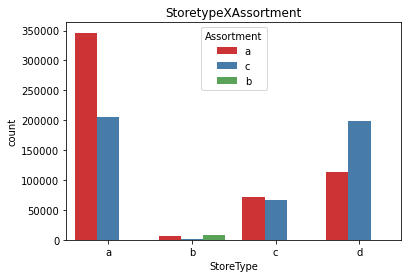

In [25]:
StypeXAssortment(train_store)

- Storetype a,c, and d dont have the assortment b
- Storetype b has all the 3 assortments but that is very minial when comapred to other storetypes
- Also from the graph we can say that high count of 'a' storetype and least count of storetype 'c'
- On the whole we can deduce a and c assortment are common across all stores.

Monthly Sales with and Without Promo


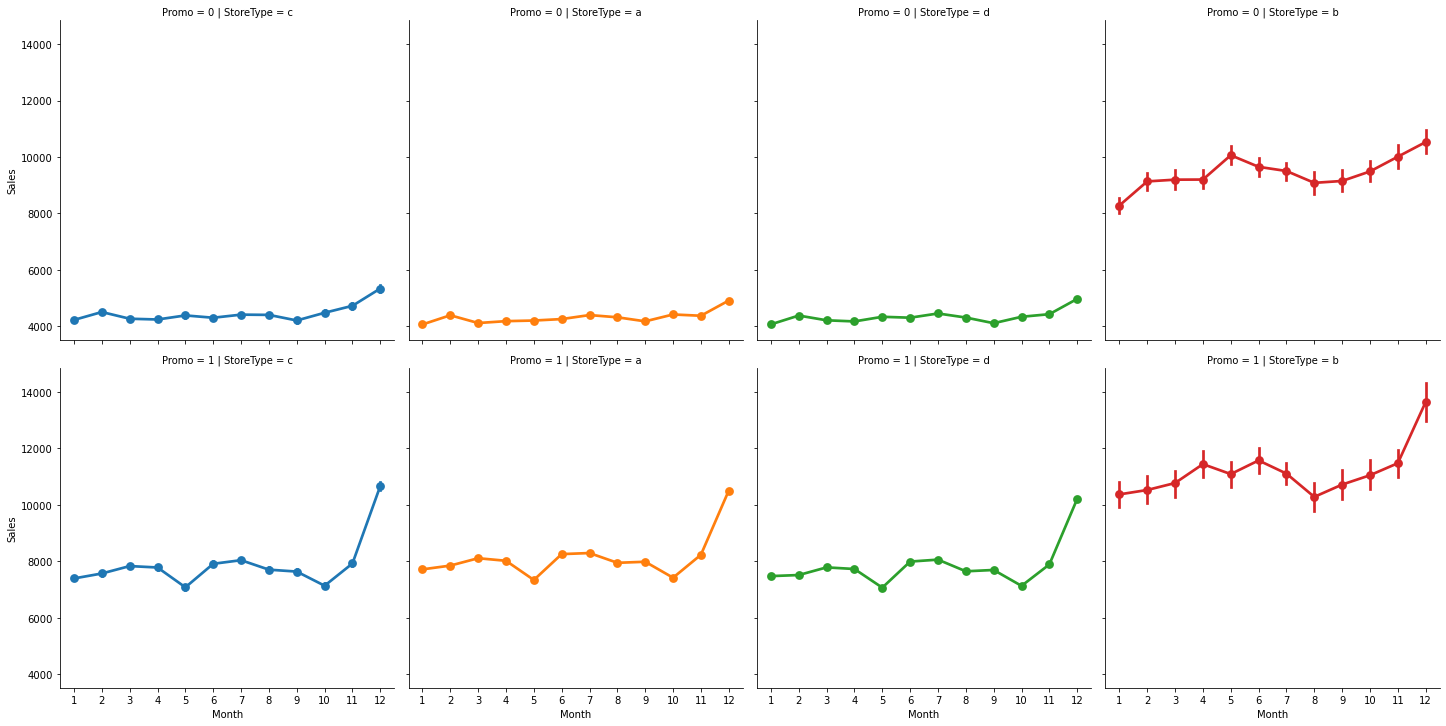

Monthly Customers with and Without Promo


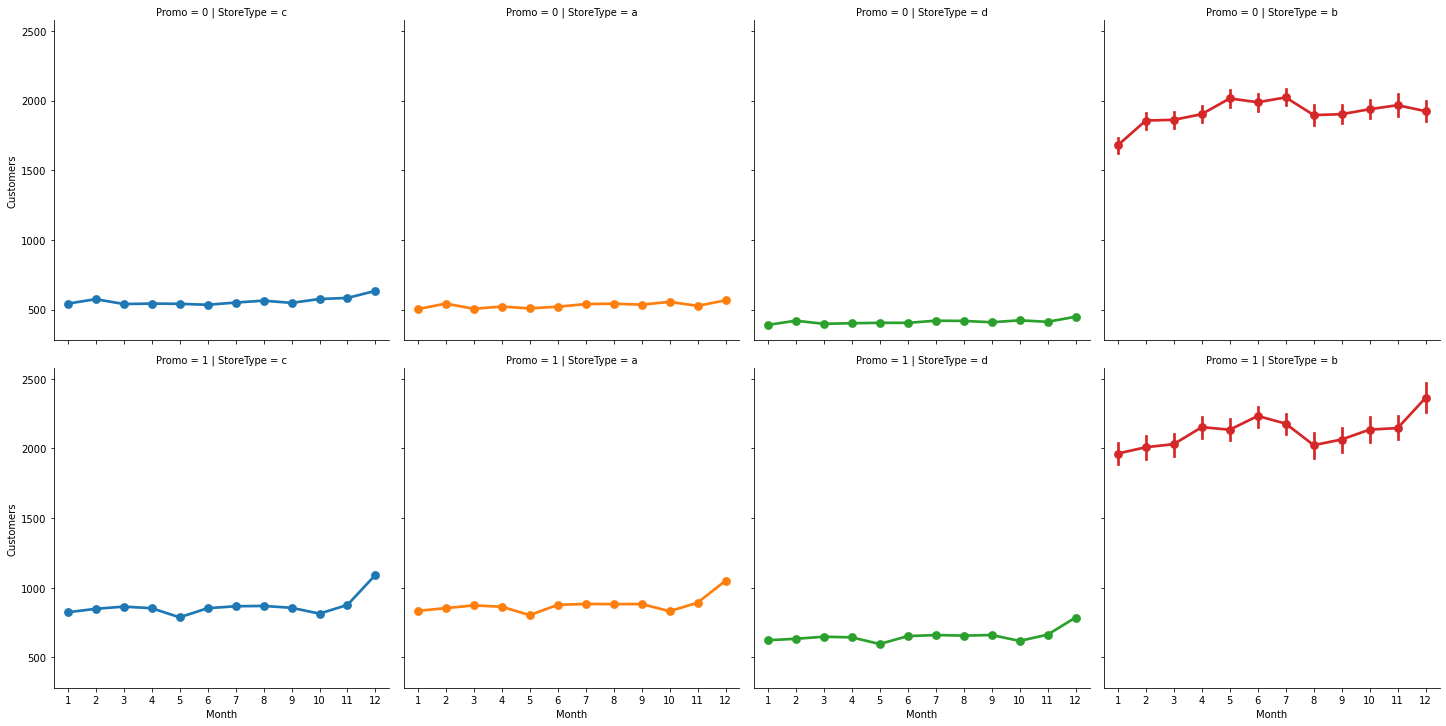

In [26]:
promoSales(train_store)

When checked on the whole data
- The sales seems to be significant rise in all the months when the Promo is applied, it seems to be the same case in
for the customers as well
- Also the sales and customers are high during the month of December

Monthly Sales with and Without Promo


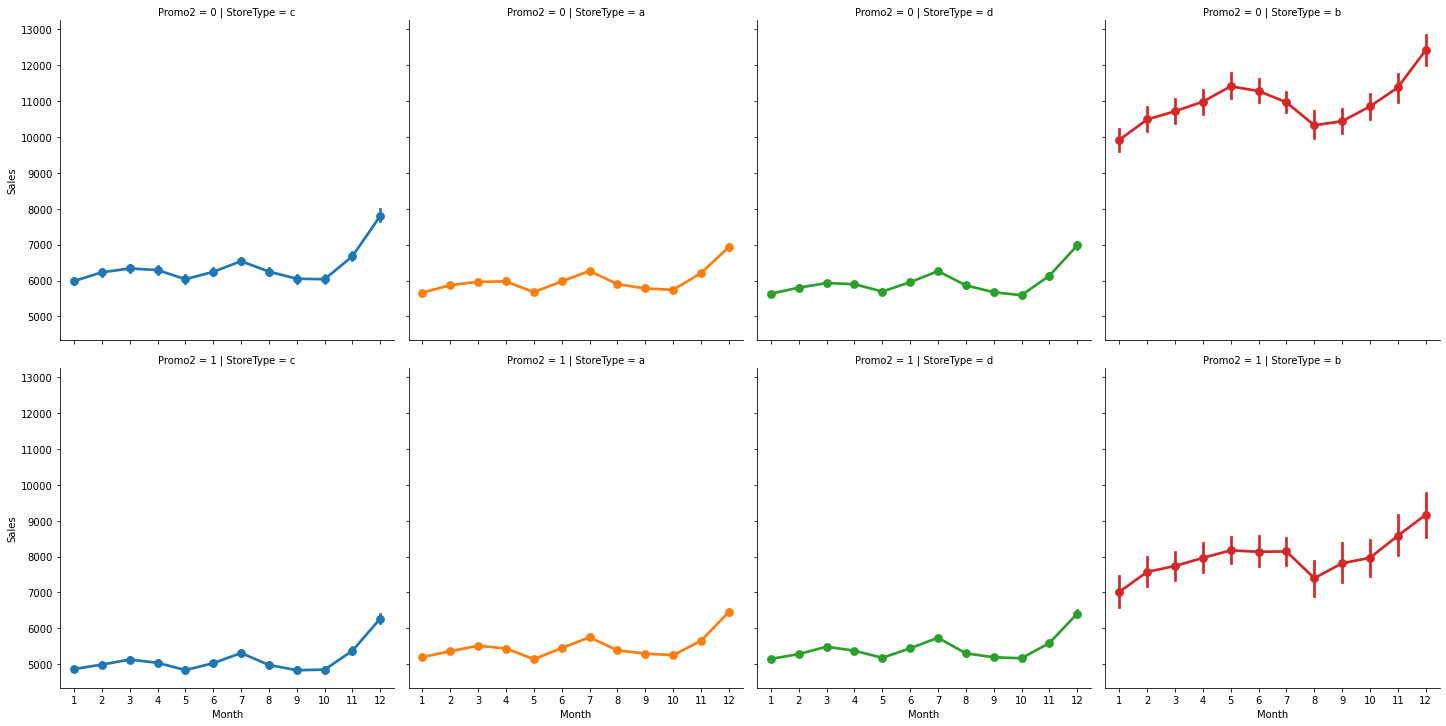

Monthly Customers with and Without Promo


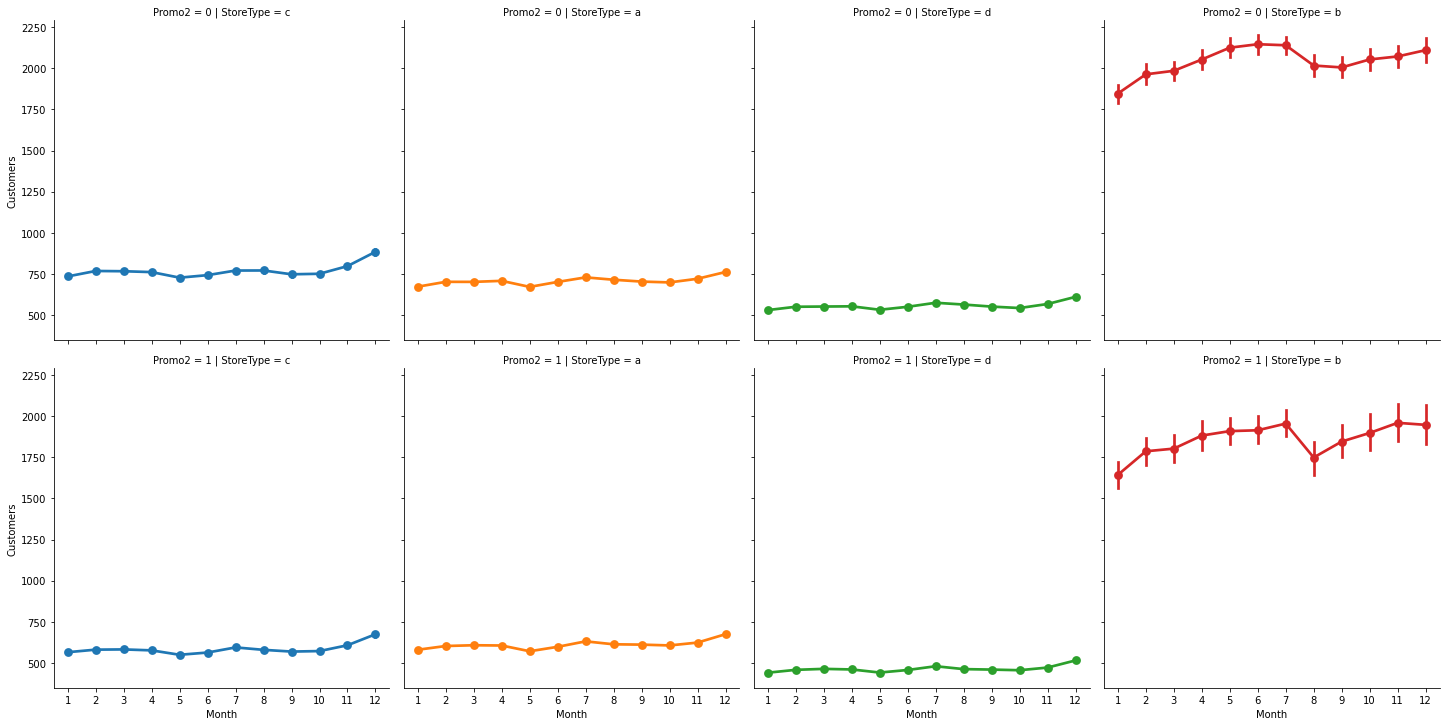

In [27]:
promo2Sales(train_store)

When checked on the whole data
- The sales seems to be significant fall in all the months when the Promo2 is applied, it seems to be the same case in
for the customers as well

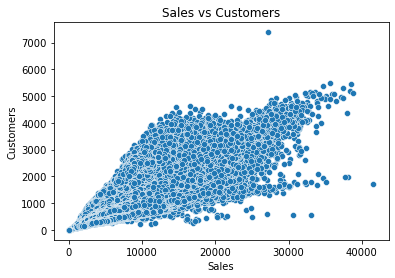

In [28]:
#Check the realtion between Sales and Customers
saleVcustomer(train_store)

- From the above scatter plot we see that the Sales and Customers are positiviely linear relationship.Also there to say we ahve very few outliers.Sicne we are checking the 9 stores priamrily we will check the outliers individually for each store

In [29]:
#Map the categorical values to numerical values 
hot_encoding(train_store)

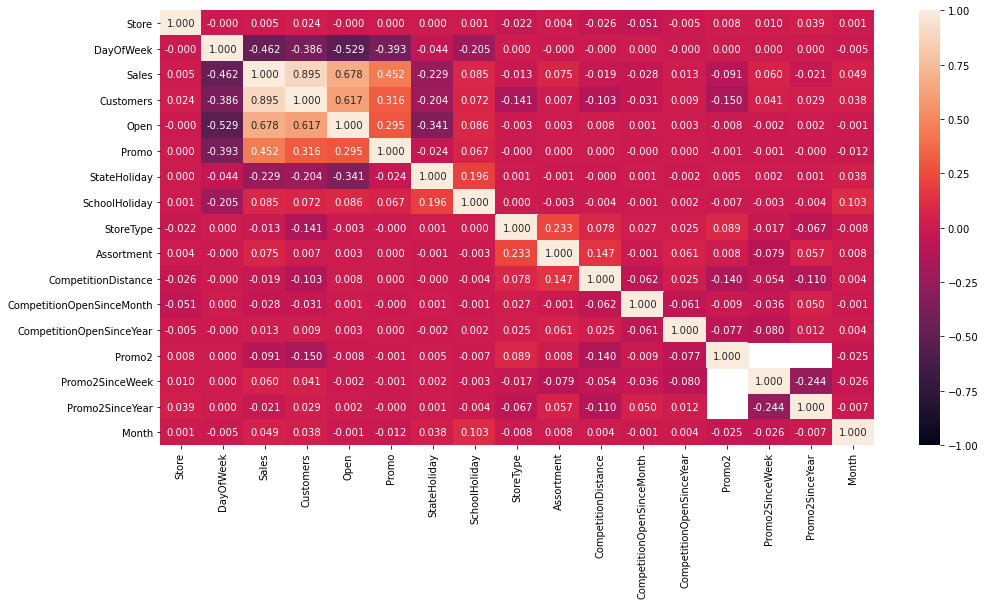

In [30]:
#Check the corelation among the variables
correlation(train_store)

**From the correlation map we can deduce**
- Customers, Open and Promo seems to have a positive corelation with Sales & Customers
- DayOfWeek, StateHoliday and Promo2 seems to have negative coraltion with Sales & Customers

In [31]:
#After careful pbservation from the corrlation graph we remove unwanted columns that we might not use in the forecast
drop_columns = ['StoreType','Assortment','CompetitionDistance','CompetitionOpenSinceMonth','CompetitionOpenSinceYear','Promo2',
                'Promo2SinceWeek','Promo2SinceYear','PromoInterval','Month']
train_store.drop(drop_columns,axis = 1, inplace = True) 

In [32]:
train_store.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype         
---  ------         --------------    -----         
 0   Store          1017209 non-null  int64         
 1   DayOfWeek      1017209 non-null  int64         
 2   Date           1017209 non-null  datetime64[ns]
 3   Sales          1017209 non-null  int64         
 4   Customers      1017209 non-null  int64         
 5   Open           1017209 non-null  int64         
 6   Promo          1017209 non-null  int64         
 7   StateHoliday   1017209 non-null  int64         
 8   SchoolHoliday  1017209 non-null  int64         
dtypes: datetime64[ns](1), int64(8)
memory usage: 77.6 MB


In [33]:
#Divide the main dataframe into 9 separate dataframes based on the key store values (1,3,8,9,13,25,29,31 and 46)
store_1 = train_store[train_store['Store']==1]
store_3 = train_store[train_store['Store']==3]
store_8 = train_store[train_store['Store']==8]
store_9 = train_store[train_store['Store']==9]
store_13 = train_store[train_store['Store']==13]
store_25 = train_store[train_store['Store']==25]
store_29 = train_store[train_store['Store']==29]
store_31 = train_store[train_store['Store']==31]
store_46 = train_store[train_store['Store']==46]

# Store 1

In [34]:
#Set Date as Index and also check the date index frequency
store_1 = store_1.set_index('Date').sort_index()
store_1.index = pd.DatetimeIndex(store_1.index.values,freq=store_1.index.inferred_freq)

#also drop the column store as we have selected columns of a single id only
store_1.drop('Store', axis = 1 , inplace = True) 

In [35]:
#Repalce any 0's in the Sales&Customers with the median value
store_1['Sales'] = np.where(store_1['Sales'] == 0,store_1['Sales'].median(),store_1['Sales'])
store_1['Customers'] = np.where(store_1['Customers'] == 0,store_1['Customers'].median(),store_1['Customers'])

In [36]:
null_value_check(store_1)

The columns that will be dropped are: []


DayOfWeek        0.0
Sales            0.0
Customers        0.0
Open             0.0
Promo            0.0
StateHoliday     0.0
SchoolHoliday    0.0
dtype: float64

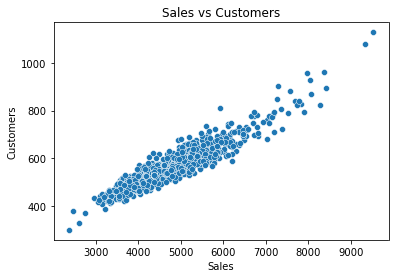

In [37]:
saleVcustomer(store_1)

- In store_1 sales and customers have a strong positive linear relationship, but as we can see there are some outliers.

Before Oulier Treatment
             Sales    Customers
count   942.000000   942.000000
mean   4693.192675   558.059448
std     932.838800    86.330523
min    2362.000000   298.000000
25%    4098.250000   507.000000
50%    4377.250000   529.000000
75%    5220.000000   598.750000
99%    7806.240000   846.310000
100%   9528.000000  1130.000000
max    9528.000000  1130.000000


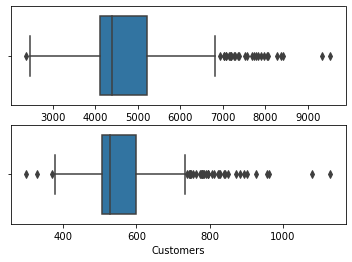

After Outlier Treatment
             Sales   Customers
count   942.000000  942.000000
mean   4687.205839  557.003291
std     908.894359   81.588042
min    2362.000000  298.000000
25%    4098.250000  507.000000
50%    4377.250000  529.000000
75%    5220.000000  598.750000
99%    7797.531600  844.132900
100%   7806.240000  846.310000
max    7806.240000  846.310000


In [38]:
outlier_check(store_1)

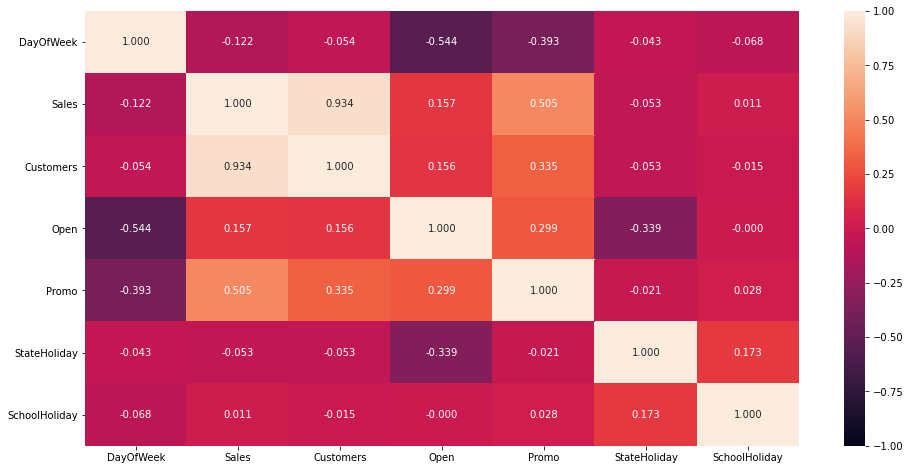

In [39]:
correlation(store_1)

In [40]:
#ADF Stationary Check
stationary_adf_test(store_1['Sales'])
stationary_adf_test(store_1['Customers'])

ADF Statistic: -5.381818
p-value: 0.000004
Critical Values @ 0.05: -2.86
ADF Statistic: -3.917384
p-value: 0.001911
Critical Values @ 0.05: -2.86


- Since both the p-values are < 0.05 we reject the null hypothesis. Sales & Customers both are stationary

In [41]:
#Defining the train and test
df1_train = store_1.loc[:train_end_date]
df1_test = store_1.loc[test_start_date:]

### store_1 VAR

                             Statespace Model Results                             
Dep. Variable:     ['Sales', 'Customers']   No. Observations:                  895
Model:                             VAR(1)   Log Likelihood              -11611.846
Date:                    Mon, 31 May 2021   AIC                          23237.691
Time:                            03:28:29   BIC                          23271.269
Sample:                        01-01-2013   HQIC                         23250.522
                             - 06-14-2015                                         
Covariance Type:                      opg                                         
Ljung-Box (L1) (Q):          127.50, 47.69   Jarque-Bera (JB):        451.17, 19.21
Prob(Q):                        0.00, 0.00   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         1.17, 0.91   Skew:                      0.25, -0.02
Prob(H) (two-sided):            0.18, 0.42   Kurtosis:                   6.44, 3.72


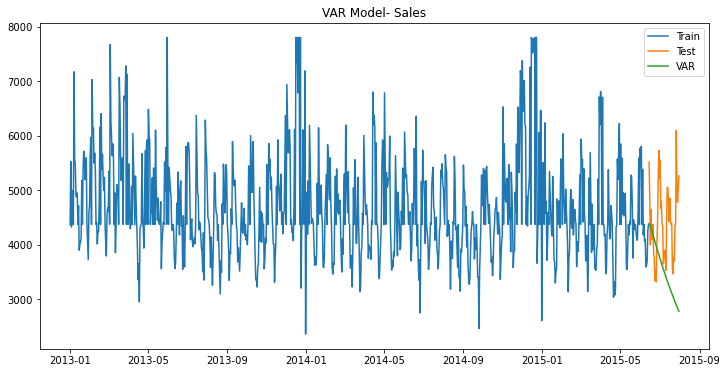

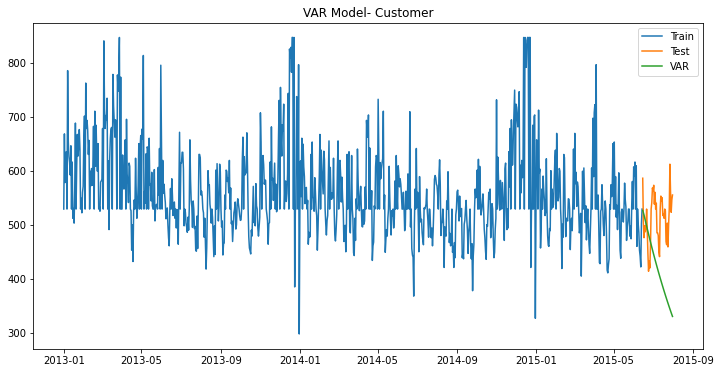

      Method   Variable     RMSE   MAPE
0  VAR_Model      Sales  1231.87  21.24
1  VAR_Model  Customers   120.61  19.55


In [42]:
s1_VAR = VAR(df1_train,df1_test)

### Store_1 VARMAX

C:\Users\acer\anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
C:\Users\acer\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                             Statespace Model Results                             
Dep. Variable:     ['Sales', 'Customers']   No. Observations:                  895
Model:                        VARMAX(1,1)   Log Likelihood              -11343.840
Date:                    Mon, 31 May 2021   AIC                          22725.680
Time:                            03:29:11   BIC                          22816.819
Sample:                        01-01-2013   HQIC                         22760.505
                             - 06-14-2015                                         
Covariance Type:                      opg                                         
Ljung-Box (L1) (Q):             2.76, 0.71   Jarque-Bera (JB):        394.20, 82.03
Prob(Q):                        0.10, 0.40   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         1.37, 0.90   Skew:                       0.87, 0.14
Prob(H) (two-sided):            0.01, 0.36   Kurtosis:                   5.75, 4.45


C:\Users\acer\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\acer\anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
C:\Users\acer\anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'


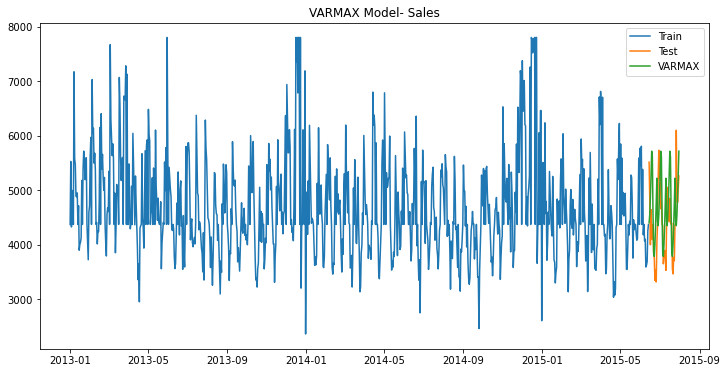

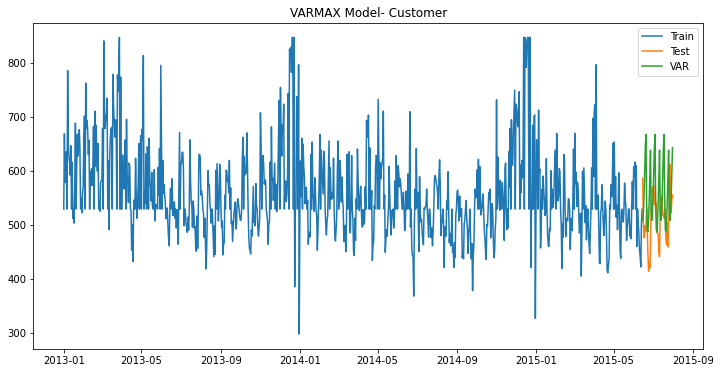

         Method   Variable    RMSE   MAPE
0  VARMAX_Model      Sales  804.63  15.07
1  VARMAX_Model  Customers   87.82  13.76


In [43]:
exog = ['DayOfWeek','Open','Promo','StateHoliday']
s1_VARMAX = VARMAX(df1_train,df1_test,exog)

### Store_1 ARIMA

                              ARMA Model Results                              
Dep. Variable:                  Sales   No. Observations:                  895
Model:                     ARMA(1, 1)   Log Likelihood               -7216.132
Method:                       css-mle   S.D. of innovations            767.820
Date:                Mon, 31 May 2021   AIC                          14440.265
Time:                        03:29:15   BIC                          14459.452
Sample:                    01-01-2013   HQIC                         14447.596
                         - 06-14-2015                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const        4700.0829     72.675     64.673      0.000    4557.643    4842.523
ar.L1.Sales     0.7772      0.030     25.601      0.000       0.718       0.837
ma.L1.Sales    -0.3669      0.040     -9.252    

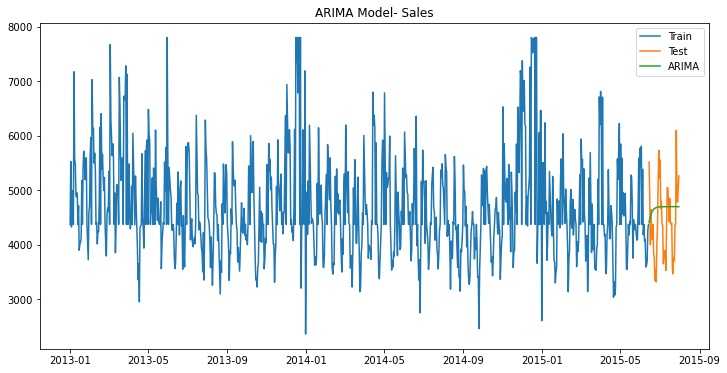

        Method Variable    RMSE   MAPE
0  ARIMA_Model    Sales  722.25  14.66


In [44]:
s1_ARIMA = ARIMA(df1_train,df1_test)

### Store_1 ARIMAX

                              ARMA Model Results                              
Dep. Variable:                  Sales   No. Observations:                  895
Model:                     ARMA(1, 1)   Log Likelihood               -7102.543
Method:                       css-mle   S.D. of innovations            676.295
Date:                Mon, 31 May 2021   AIC                          14221.086
Time:                        03:29:16   BIC                          14259.460
Sample:                    01-01-2013   HQIC                         14235.749
                         - 06-14-2015                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const         3960.1544    132.566     29.873      0.000    3700.330    4219.978
DayOfWeek       42.7630     14.670      2.915      0.004      14.010      71.516
Open           345.6485     86.989      3.97

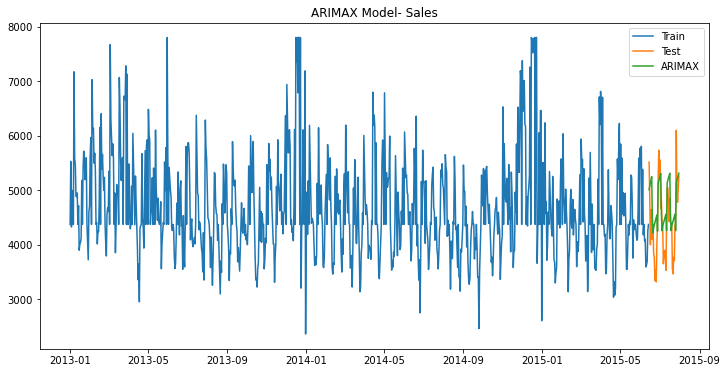

         Method Variable    RMSE  MAPE
0  ARIMAX_Model    Sales  592.05  11.8


In [45]:
s1_ARIMAX = ARIMAX(df1_train,df1_test,exog)

### Store_1 SARIMA

                                     SARIMAX Results                                      
Dep. Variable:                              Sales   No. Observations:                  895
Model:             SARIMAX(1, 0, 1)x(1, 1, 1, 12)   Log Likelihood               -7150.754
Date:                            Mon, 31 May 2021   AIC                          14311.507
Time:                                    03:29:18   BIC                          14335.424
Sample:                                01-01-2013   HQIC                         14320.652
                                     - 06-14-2015                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7866      0.025     31.073      0.000       0.737       0.836
ma.L1         -0.3770      0.046   

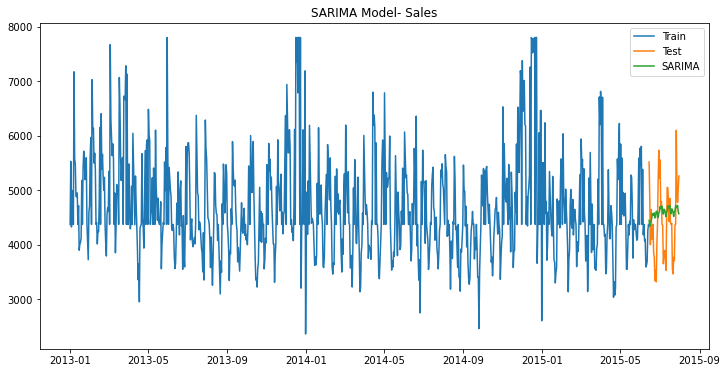

         Method Variable    RMSE   MAPE
0  SARIMA_Model    Sales  679.39  13.59


In [46]:
s1_SARIMA = SARIMA(df1_train,df1_test)

### Store_1 SARIMAX

                                     SARIMAX Results                                      
Dep. Variable:                              Sales   No. Observations:                  895
Model:             SARIMAX(1, 0, 1)x(1, 1, 1, 12)   Log Likelihood               -7060.864
Date:                            Mon, 31 May 2021   AIC                          14139.728
Time:                                    03:29:22   BIC                          14182.778
Sample:                                01-01-2013   HQIC                         14156.189
                                     - 06-14-2015                                         
Covariance Type:                              opg                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
DayOfWeek       43.5859     14.479      3.010      0.003      15.207      71.965
Open            90.4988     9

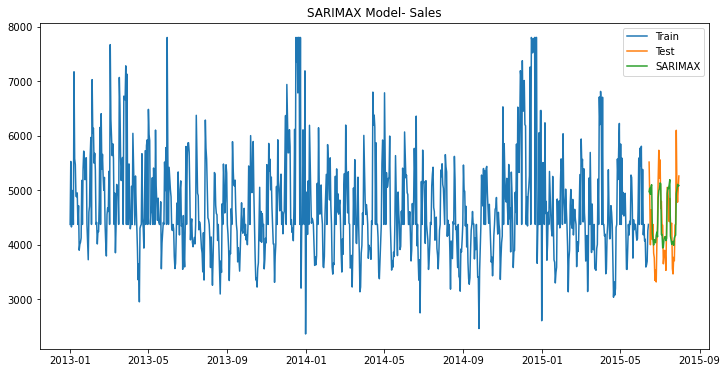

          Method Variable    RMSE  MAPE
0  SARIMAX_Model    Sales  454.72  8.93


In [47]:
s1_SARIMAX = SARIMAX(df1_train,df1_test,exog)

In [48]:
store_1_rmses = pd.concat([s1_VAR,s1_VARMAX,s1_ARIMA,s1_ARIMAX,s1_SARIMA,s1_SARIMAX])
store_1_rmses

Method   Variable     RMSE   MAPE
0      VAR_Model      Sales  1231.87  21.24
1      VAR_Model  Customers   120.61  19.55
0   VARMAX_Model      Sales   804.63  15.07
1   VARMAX_Model  Customers    87.82  13.76
0    ARIMA_Model      Sales   722.25  14.66
0   ARIMAX_Model      Sales   592.05  11.80
0   SARIMA_Model      Sales   679.39  13.59
0  SARIMAX_Model      Sales   454.72   8.93

**For store_1 multi variate time series(Sales & Customers) VARMAX model yield good results and for Single time Series(Sales) SARIMAX model provides good forecast**

# Store 3 

In [49]:
#Set Date as Index and also check the date index frequency
store_3 = store_3.set_index('Date').sort_index()
store_3.index = pd.DatetimeIndex(store_3.index.values,freq=store_3.index.inferred_freq)

#also drop the column store as we have selected columns of a single id only
store_3.drop('Store', axis = 1 , inplace = True) 

In [50]:
#Repalce any 0's in the Sales&Customers with the median value
store_3['Sales'] = np.where(store_3['Sales'] == 0,store_3['Sales'].median(),store_3['Sales'])
store_3['Customers'] = np.where(store_3['Customers'] == 0,store_3['Customers'].median(),store_3['Customers'])

In [51]:
null_value_check(store_3)

The columns that will be dropped are: []


DayOfWeek        0.0
Sales            0.0
Customers        0.0
Open             0.0
Promo            0.0
StateHoliday     0.0
SchoolHoliday    0.0
dtype: float64

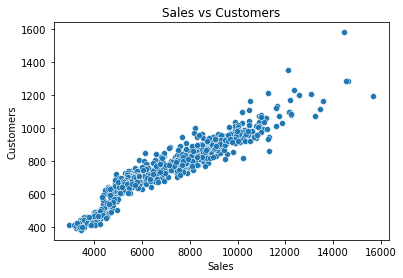

In [52]:
saleVcustomer(store_3)

- In store_3 we can see that Sales & Customers are positively and linearly realted, also outliers are present

Before Oulier Treatment
              Sales    Customers
count    942.000000   942.000000
mean    6760.782378   742.277070
std     2033.637985   155.768632
min     2936.000000   381.000000
25%     5420.000000   678.000000
50%     5896.000000   705.000000
75%     8152.750000   834.750000
99%    12314.280000  1166.180000
100%   15689.000000  1579.000000
max    15689.000000  1579.000000


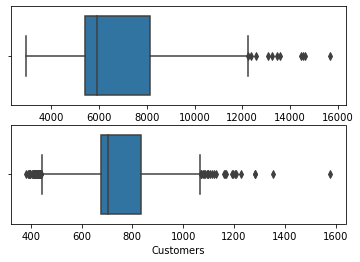

After Outlier Treatment
              Sales    Customers
count    942.000000   942.000000
mean    6745.370276   741.180255
std     1982.721422   151.907012
min     2936.000000   381.000000
25%     5420.000000   678.000000
50%     5896.000000   705.000000
75%     8152.750000   834.750000
99%    12292.025200  1165.696200
100%   12314.280000  1166.180000
max    12314.280000  1166.180000


In [53]:
outlier_check(store_3)

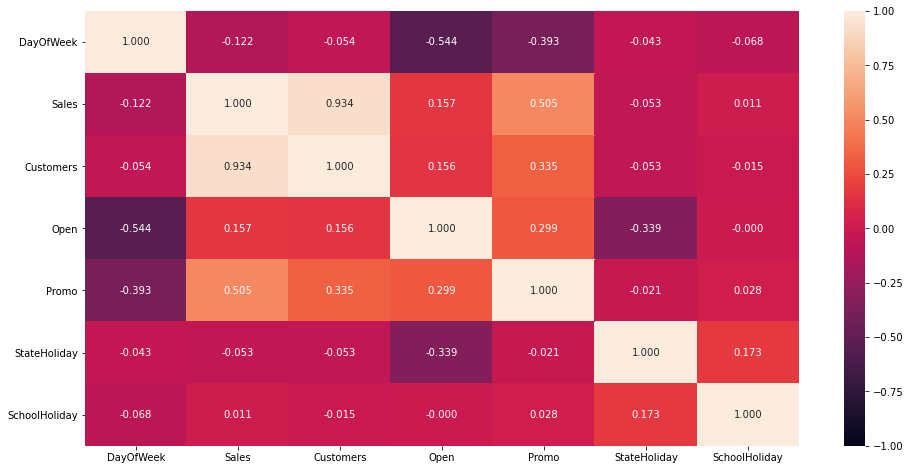

In [54]:
correlation(store_3)

In [55]:
#ADF Stationary Check
stationary_adf_test(store_3['Sales'])
stationary_adf_test(store_3['Customers'])

ADF Statistic: -5.956060
p-value: 0.000000
Critical Values @ 0.05: -2.86
ADF Statistic: -5.404573
p-value: 0.000003
Critical Values @ 0.05: -2.86


- Since both the p-values are < 0.05 we reject the null hypothesis. Sales & Customers both are stationary.

In [56]:
df3_train = store_3.loc[:train_end_date]
df3_test = store_3.loc[test_start_date:] 

                             Statespace Model Results                             
Dep. Variable:     ['Sales', 'Customers']   No. Observations:                  895
Model:                             VAR(1)   Log Likelihood              -12971.013
Date:                    Mon, 31 May 2021   AIC                          25956.025
Time:                            03:29:24   BIC                          25989.603
Sample:                        01-01-2013   HQIC                         25968.855
                             - 06-14-2015                                         
Covariance Type:                      opg                                         
Ljung-Box (L1) (Q):          17.38, 117.61   Jarque-Bera (JB):         28.94, 18.46
Prob(Q):                        0.00, 0.00   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         0.88, 1.27   Skew:                      0.20, -0.35
Prob(H) (two-sided):            0.25, 0.04   Kurtosis:                   3.78, 3.06


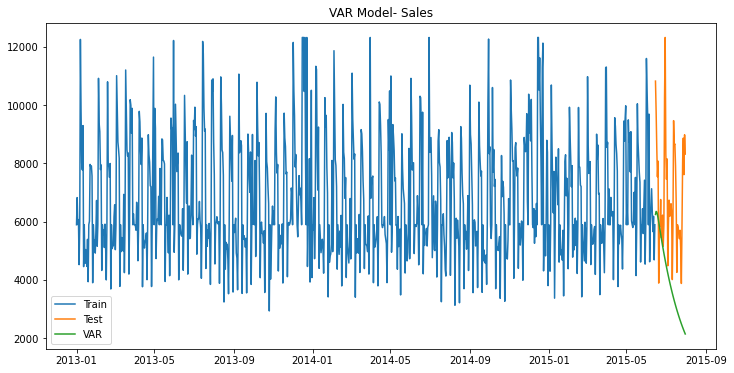

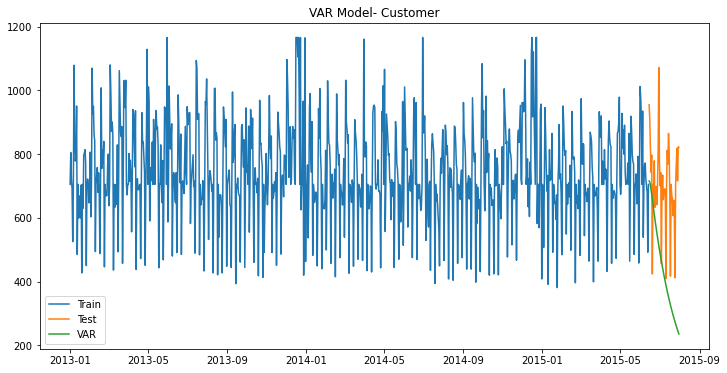

      Method   Variable     RMSE   MAPE
0  VAR_Model      Sales  3587.35  40.46
1  VAR_Model  Customers   320.00  37.92


In [57]:
s3_VAR = VAR(df3_train,df3_test)

C:\Users\acer\anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
C:\Users\acer\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                             Statespace Model Results                             
Dep. Variable:     ['Sales', 'Customers']   No. Observations:                  895
Model:                        VARMAX(1,1)   Log Likelihood              -12552.571
Date:                    Mon, 31 May 2021   AIC                          25143.142
Time:                            03:30:05   BIC                          25234.282
Sample:                        01-01-2013   HQIC                         25177.967
                             - 06-14-2015                                         
Covariance Type:                      opg                                         
Ljung-Box (L1) (Q):            22.81, 1.91   Jarque-Bera (JB):          7.34, 22.97
Prob(Q):                        0.00, 0.17   Prob(JB):                   0.03, 0.00
Heteroskedasticity (H):         1.02, 1.06   Skew:                      0.14, -0.36
Prob(H) (two-sided):            0.86, 0.64   Kurtosis:                   3.35, 3.31


C:\Users\acer\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\acer\anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
C:\Users\acer\anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'


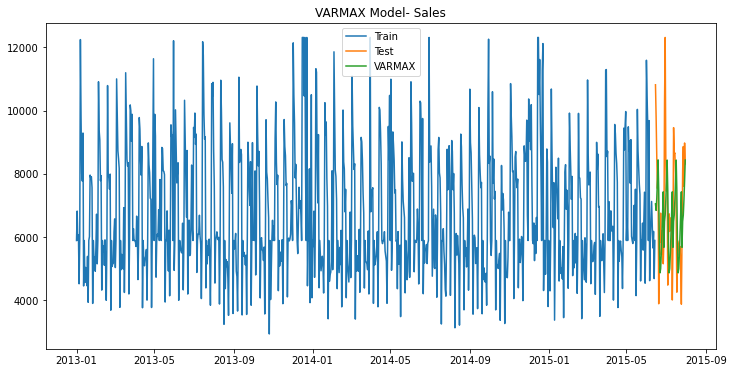

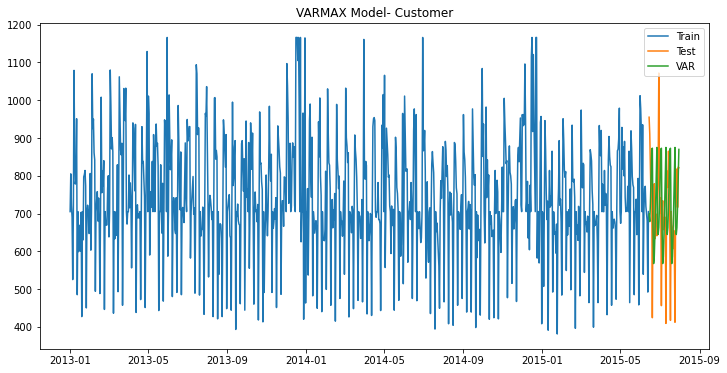

         Method   Variable     RMSE   MAPE
0  VARMAX_Model      Sales  1932.03  22.05
1  VARMAX_Model  Customers   192.36  23.31


In [58]:
exog = ['DayOfWeek','Open','Promo','StateHoliday']
s3_VARMAX = VARMAX(df3_train,df3_test,exog)

                              ARMA Model Results                              
Dep. Variable:                  Sales   No. Observations:                  895
Model:                     ARMA(1, 1)   Log Likelihood               -7972.302
Method:                       css-mle   S.D. of innovations           1787.445
Date:                Mon, 31 May 2021   AIC                          15952.603
Time:                        03:30:10   BIC                          15971.790
Sample:                    01-01-2013   HQIC                         15959.935
                         - 06-14-2015                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const        6736.1838    104.413     64.515      0.000    6531.538    6940.830
ar.L1.Sales     0.4084      0.072      5.678      0.000       0.267       0.549
ma.L1.Sales     0.0348      0.079      0.438    

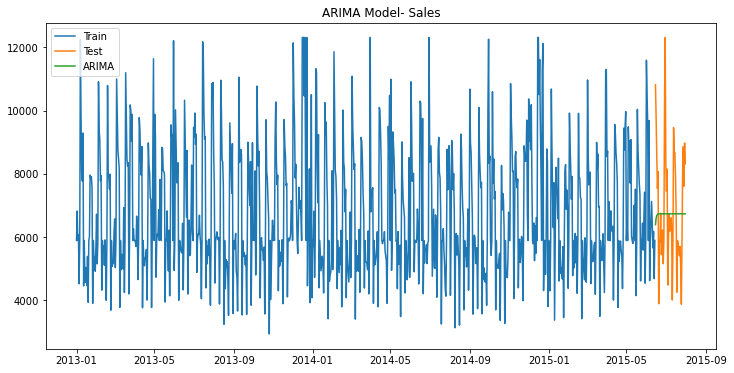

        Method Variable     RMSE   MAPE
0  ARIMA_Model    Sales  1893.44  22.82


In [59]:
s3_ARIMA = ARIMA(df3_train,df3_test)

                              ARMA Model Results                              
Dep. Variable:                  Sales   No. Observations:                  895
Model:                     ARMA(1, 1)   Log Likelihood               -7478.038
Method:                       css-mle   S.D. of innovations           1028.886
Date:                Mon, 31 May 2021   AIC                          14972.075
Time:                        03:30:11   BIC                          15010.450
Sample:                    01-01-2013   HQIC                         14986.738
                         - 06-14-2015                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const         7968.3698    192.574     41.378      0.000    7590.932    8345.808
DayOfWeek     -312.0569     21.284    -14.662      0.000    -353.772    -270.342
Open         -1315.8904    113.241    -11.62

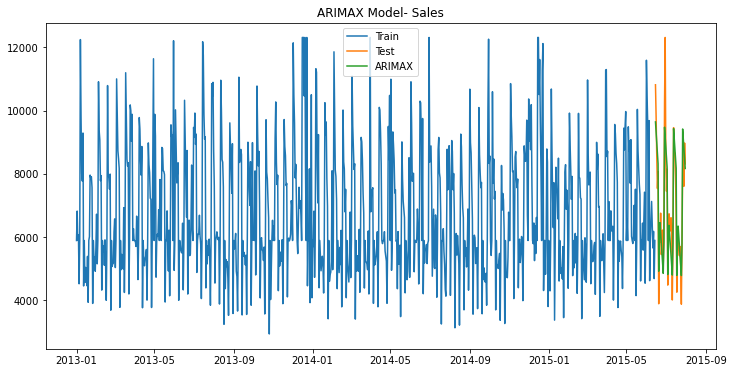

         Method Variable    RMSE  MAPE
0  ARIMAX_Model    Sales  806.25  8.64


In [60]:
s3_ARIMAX = ARIMAX(df3_train,df3_test,exog)

C:\Users\acer\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                     SARIMAX Results                                      
Dep. Variable:                              Sales   No. Observations:                  895
Model:             SARIMAX(1, 0, 1)x(1, 1, 1, 12)   Log Likelihood               -7894.733
Date:                            Mon, 31 May 2021   AIC                          15799.465
Time:                                    03:30:13   BIC                          15823.382
Sample:                                01-01-2013   HQIC                         15808.610
                                     - 06-14-2015                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5308      0.064      8.252      0.000       0.405       0.657
ma.L1         -0.0627      0.070   

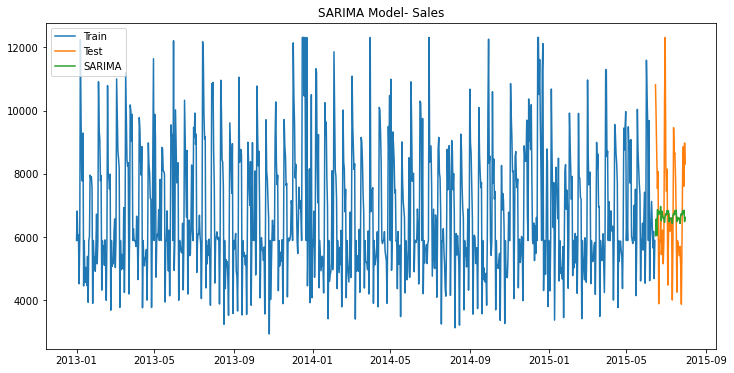

         Method Variable     RMSE   MAPE
0  SARIMA_Model    Sales  1911.45  22.29


In [61]:
s3_SARIMA = SARIMA(df3_train,df3_test)

C:\Users\acer\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                     SARIMAX Results                                      
Dep. Variable:                              Sales   No. Observations:                  895
Model:             SARIMAX(1, 0, 1)x(1, 1, 1, 12)   Log Likelihood               -7422.513
Date:                            Mon, 31 May 2021   AIC                          14863.027
Time:                                    03:30:17   BIC                          14906.076
Sample:                                01-01-2013   HQIC                         14879.487
                                     - 06-14-2015                                         
Covariance Type:                              opg                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
DayOfWeek     -254.2494     21.729    -11.701      0.000    -296.838    -211.661
Open         -1242.6432    18

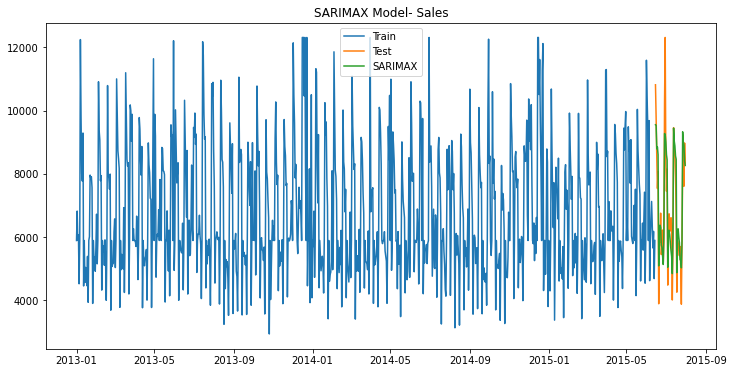

          Method Variable    RMSE  MAPE
0  SARIMAX_Model    Sales  829.95  9.21


In [62]:
s3_SARIMAX = SARIMAX(df3_train,df3_test,exog)

In [63]:
store_3_rmses = pd.concat([s3_VAR,s3_VARMAX,s3_ARIMA,s3_ARIMAX,s3_SARIMA,s3_SARIMAX])
store_3_rmses

Method   Variable     RMSE   MAPE
0      VAR_Model      Sales  3587.35  40.46
1      VAR_Model  Customers   320.00  37.92
0   VARMAX_Model      Sales  1932.03  22.05
1   VARMAX_Model  Customers   192.36  23.31
0    ARIMA_Model      Sales  1893.44  22.82
0   ARIMAX_Model      Sales   806.25   8.64
0   SARIMA_Model      Sales  1911.45  22.29
0  SARIMAX_Model      Sales   829.95   9.21

**For store_3 multi variate time series(Sales & Customers) VARMAX model yield good results and for Single time Series(Sales) SARIMAX model provides good forecast**

# Store 8

In [64]:
#Set Date as Index and also check the date index frequency
store_8 = store_8.set_index('Date').sort_index()
store_8.index = pd.DatetimeIndex(store_8.index.values,freq=store_8.index.inferred_freq)

In [65]:
#also drop the column store as we have selected columns of a single id only
store_8.drop('Store', axis = 1 , inplace = True) 

In [66]:
#Repalce any 0's in the Sales&Customers with the median value
store_8['Sales'] = np.where(store_8['Sales'] == 0,store_8['Sales'].median(),store_8['Sales'])
store_8['Customers'] = np.where(store_8['Customers'] == 0,store_8['Customers'].median(),store_8['Customers'])

In [67]:
null_value_check(store_8)

The columns that will be dropped are: []


DayOfWeek        0.0
Sales            0.0
Customers        0.0
Open             0.0
Promo            0.0
StateHoliday     0.0
SchoolHoliday    0.0
dtype: float64

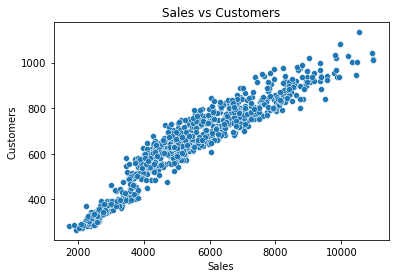

In [68]:
saleVcustomer(store_8)

- Sales & Customers in store_8 have a positive linear relationship

Before Oulier Treatment
              Sales    Customers
count    942.000000   942.000000
mean    5435.306794   653.552017
std     1743.270927   160.165959
min     1725.000000   266.000000
25%     4403.250000   588.250000
50%     4920.000000   630.750000
75%     6558.000000   759.750000
99%     9914.040000  1002.770000
100%   10971.000000  1133.000000
max    10971.000000  1133.000000


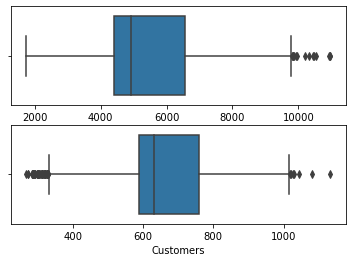

After Outlier Treatment
             Sales    Customers
count   942.000000   942.000000
mean   5429.396391   653.173779
std    1726.626692   159.248623
min    1725.000000   266.000000
25%    4403.250000   588.250000
50%    4920.000000   630.750000
75%    6558.000000   759.750000
99%    9900.493600  1002.044300
100%   9914.040000  1002.770000
max    9914.040000  1002.770000


In [69]:
outlier_check(store_8)

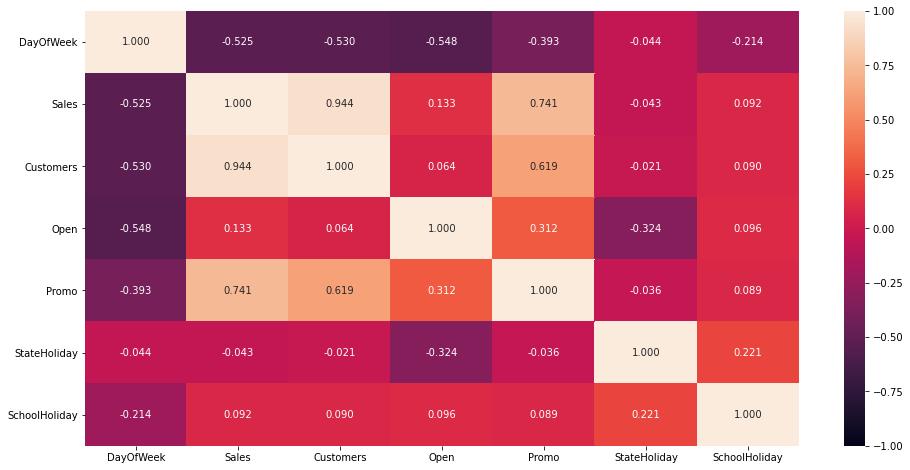

In [70]:
correlation(store_8)

In [71]:
#ADF Stationary Check
stationary_adf_test(store_8['Sales'])
stationary_adf_test(store_8['Customers'])

ADF Statistic: -3.422704
p-value: 0.010209
Critical Values @ 0.05: -2.86
ADF Statistic: -3.231252
p-value: 0.018245
Critical Values @ 0.05: -2.86


- Since both the p-values are < 0.05 we reject the null hypothesis. Sales & Customers both are stationary.

In [72]:
df8_train = store_8.loc[:train_end_date]
df8_test = store_8.loc[test_start_date:] 

                             Statespace Model Results                             
Dep. Variable:     ['Sales', 'Customers']   No. Observations:                  895
Model:                             VAR(1)   Log Likelihood              -12853.450
Date:                    Mon, 31 May 2021   AIC                          25720.900
Time:                            03:30:19   BIC                          25754.478
Sample:                        01-01-2013   HQIC                         25733.731
                             - 06-14-2015                                         
Covariance Type:                      opg                                         
Ljung-Box (L1) (Q):            0.75, 44.98   Jarque-Bera (JB):         25.83, 27.73
Prob(Q):                        0.39, 0.00   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         1.09, 1.17   Skew:                      0.40, -0.43
Prob(H) (two-sided):            0.48, 0.18   Kurtosis:                   2.75, 2.90


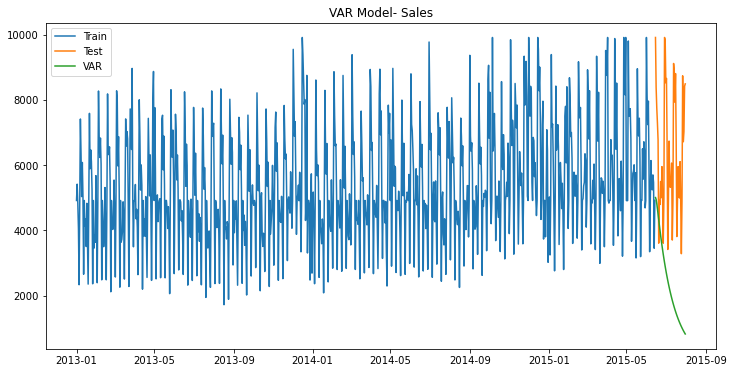

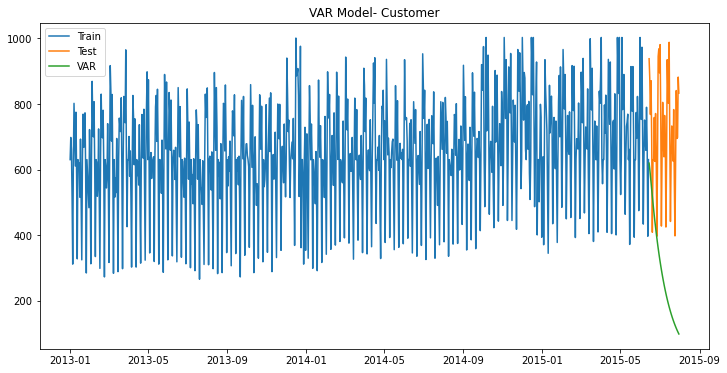

      Method   Variable     RMSE   MAPE
0  VAR_Model      Sales  4496.58  59.39
1  VAR_Model  Customers   473.80  58.46


In [73]:
s8_VAR = VAR(df8_train,df8_test)

C:\Users\acer\anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
C:\Users\acer\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                             Statespace Model Results                             
Dep. Variable:     ['Sales', 'Customers']   No. Observations:                  895
Model:                        VARMAX(1,1)   Log Likelihood              -12565.237
Date:                    Mon, 31 May 2021   AIC                          25168.475
Time:                            03:31:02   BIC                          25259.614
Sample:                        01-01-2013   HQIC                         25203.300
                             - 06-14-2015                                         
Covariance Type:                      opg                                         
Ljung-Box (L1) (Q):            22.39, 1.68   Jarque-Bera (JB):          3.02, 10.40
Prob(Q):                        0.00, 0.20   Prob(JB):                   0.22, 0.01
Heteroskedasticity (H):         1.07, 1.19   Skew:                      -0.07, 0.22
Prob(H) (two-sided):            0.54, 0.13   Kurtosis:                   2.75, 3.29


C:\Users\acer\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\acer\anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
C:\Users\acer\anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'


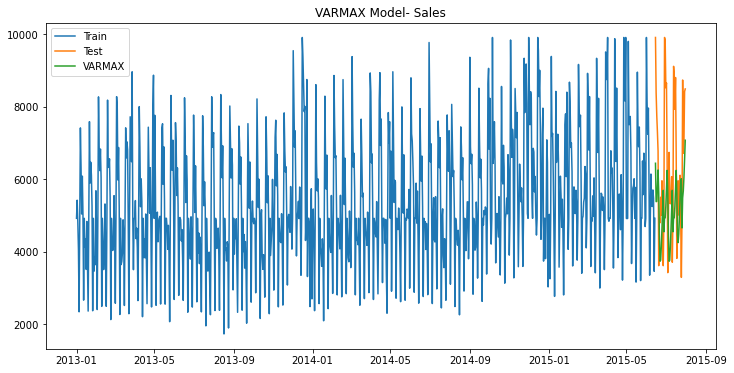

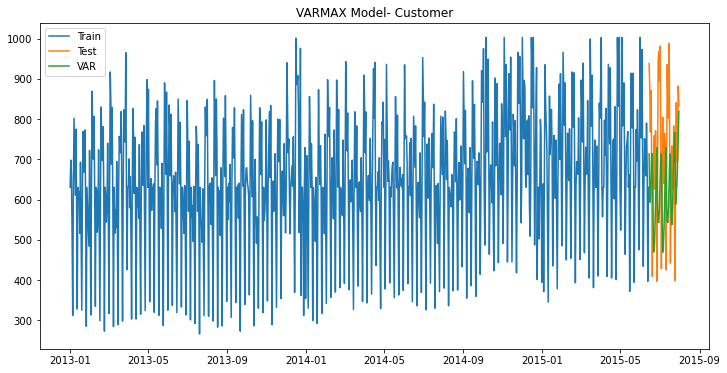

         Method   Variable     RMSE   MAPE
0  VARMAX_Model      Sales  2166.39  27.42
1  VARMAX_Model  Customers   220.36  27.22


In [74]:
exog = ['DayOfWeek','Open','Promo','SchoolHoliday']
s8_VARMAX = VARMAX(df8_train,df8_test,exog)

                              ARMA Model Results                              
Dep. Variable:                  Sales   No. Observations:                  895
Model:                     ARMA(1, 1)   Log Likelihood               -7798.812
Method:                       css-mle   S.D. of innovations           1472.331
Date:                Mon, 31 May 2021   AIC                          15605.625
Time:                        03:31:06   BIC                          15624.812
Sample:                    01-01-2013   HQIC                         15612.957
                         - 06-14-2015                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const        5381.6696     79.251     67.907      0.000    5226.341    5536.998
ar.L1.Sales     0.0490      0.051      0.959      0.338      -0.051       0.149
ma.L1.Sales     0.5320      0.040     13.343    

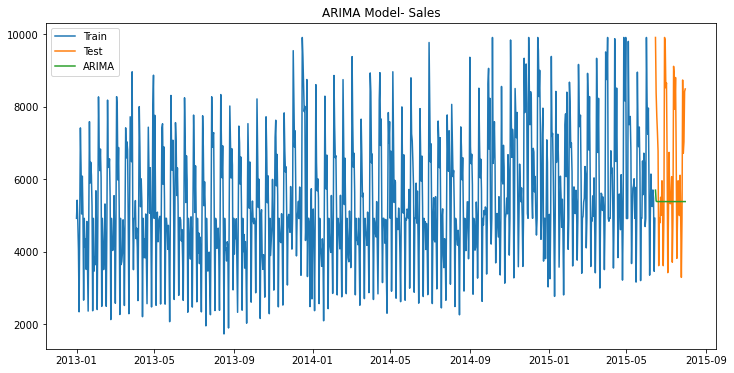

        Method Variable     RMSE   MAPE
0  ARIMA_Model    Sales  2096.57  24.36


In [75]:
s8_ARIMA = ARIMA(df8_train,df8_test)

                              ARMA Model Results                              
Dep. Variable:                  Sales   No. Observations:                  895
Model:                     ARMA(1, 1)   Log Likelihood               -7332.858
Method:                       css-mle   S.D. of innovations            874.472
Date:                Mon, 31 May 2021   AIC                          14681.715
Time:                        03:31:08   BIC                          14720.090
Sample:                    01-01-2013   HQIC                         14696.379
                         - 06-14-2015                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const          7263.2778    269.735     26.927      0.000    6734.607    7791.948
DayOfWeek      -376.5045     18.136    -20.760      0.000    -412.051    -340.959
Open          -1445.6396     91.560    -

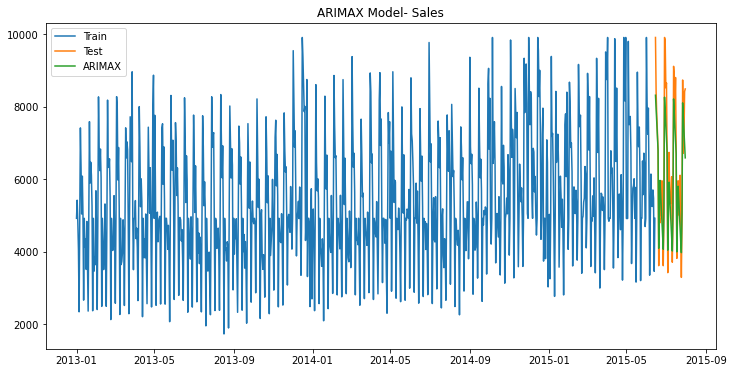

         Method Variable    RMSE  MAPE
0  ARIMAX_Model    Sales  881.03  10.1


In [76]:
s8_ARIMAX = ARIMAX(df8_train,df8_test,exog)

                                     SARIMAX Results                                      
Dep. Variable:                              Sales   No. Observations:                  895
Model:             SARIMAX(1, 0, 1)x(1, 1, 1, 12)   Log Likelihood               -7706.313
Date:                            Mon, 31 May 2021   AIC                          15422.626
Time:                                    03:31:10   BIC                          15446.543
Sample:                                01-01-2013   HQIC                         15431.771
                                     - 06-14-2015                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3738      0.067      5.587      0.000       0.243       0.505
ma.L1          0.2485      0.065   

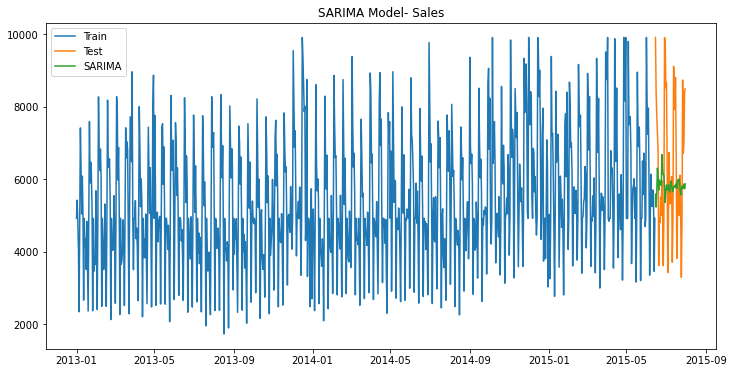

         Method Variable     RMSE   MAPE
0  SARIMA_Model    Sales  2021.05  26.41


In [77]:
s8_SARIMA = SARIMA(df8_train,df8_test)

C:\Users\acer\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                     SARIMAX Results                                      
Dep. Variable:                              Sales   No. Observations:                  895
Model:             SARIMAX(1, 0, 1)x(1, 1, 1, 12)   Log Likelihood               -7345.158
Date:                            Mon, 31 May 2021   AIC                          14708.316
Time:                                    03:31:15   BIC                          14751.366
Sample:                                01-01-2013   HQIC                         14724.777
                                     - 06-14-2015                                         
Covariance Type:                              opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
DayOfWeek      -347.1813     19.388    -17.907      0.000    -385.181    -309.181
Open          -1705.8812  

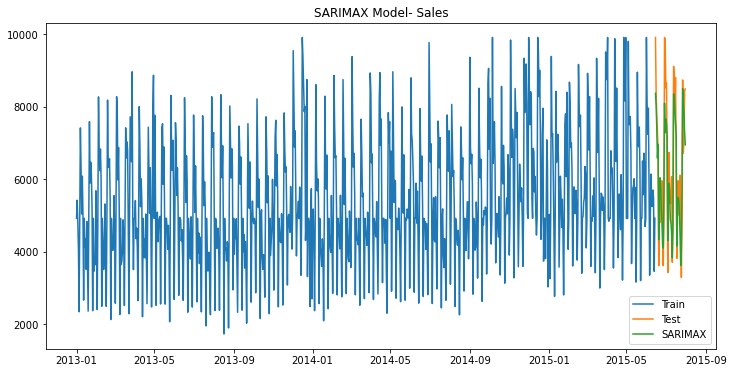

          Method Variable    RMSE   MAPE
0  SARIMAX_Model    Sales  942.83  12.54


In [78]:
s8_SARIMAX = SARIMAX(df8_train,df8_test,exog)

In [79]:
store_8_rmses = pd.concat([s8_VAR,s8_VARMAX,s8_ARIMA,s8_ARIMAX,s8_SARIMA,s8_SARIMAX])
store_8_rmses

Method   Variable     RMSE   MAPE
0      VAR_Model      Sales  4496.58  59.39
1      VAR_Model  Customers   473.80  58.46
0   VARMAX_Model      Sales  2166.39  27.42
1   VARMAX_Model  Customers   220.36  27.22
0    ARIMA_Model      Sales  2096.57  24.36
0   ARIMAX_Model      Sales   881.03  10.10
0   SARIMA_Model      Sales  2021.05  26.41
0  SARIMAX_Model      Sales   942.83  12.54

**For store_8 multi variate time series(Sales & Customers) VARMAX model yield good results and for Single time Series(Sales) ARIMAX model provides good forecast**

# Store 9

In [80]:
#Set Date as Index and also check the date index frequency
store_9 = store_9.set_index('Date').sort_index()
store_9.index = pd.DatetimeIndex(store_9.index.values,freq=store_9.index.inferred_freq)

In [81]:
#also drop the column store as we have selected columns of a single id only
store_9.drop('Store', axis = 1 , inplace = True) 

In [82]:
#Repalce any 0's in the Sales&Customers with the median value
store_9['Sales'] = np.where(store_9['Sales'] == 0,store_9['Sales'].median(),store_9['Sales'])
store_9['Customers'] = np.where(store_9['Customers'] == 0,store_9['Customers'].median(),store_9['Customers'])

In [83]:
null_value_check(store_9)

The columns that will be dropped are: []


DayOfWeek        0.0
Sales            0.0
Customers        0.0
Open             0.0
Promo            0.0
StateHoliday     0.0
SchoolHoliday    0.0
dtype: float64

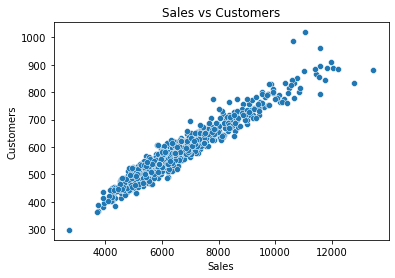

In [84]:
saleVcustomer(store_9)

Before Oulier Treatment
              Sales    Customers
count    942.000000   942.000000
mean    6448.507962   572.753715
std     1501.677509    95.068759
min     2724.000000   297.000000
25%     5563.250000   519.250000
50%     5904.750000   539.000000
75%     7086.750000   620.750000
99%    11548.880000   880.360000
100%   13457.000000  1019.000000
max    13457.000000  1019.000000


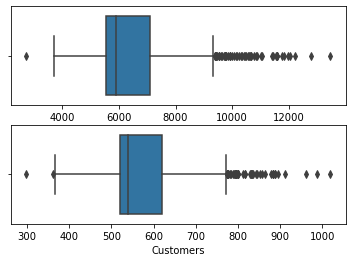

After Outlier Treatment
              Sales   Customers
count    942.000000  942.000000
mean    6442.935563  572.332909
std     1480.403957   93.475420
min     2724.000000  297.000000
25%     5563.250000  519.250000
50%     5904.750000  539.000000
75%     7086.750000  620.750000
99%    11541.139200  879.392400
100%   11548.880000  880.360000
max    11548.880000  880.360000


In [85]:
outlier_check(store_9)

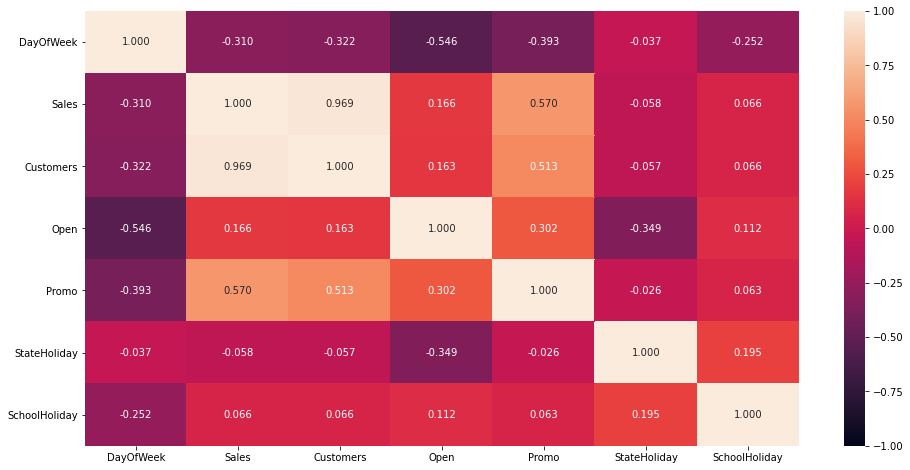

In [86]:
correlation(store_9)

In [87]:
#ADF Stationary Check
stationary_adf_test(store_9['Sales'])
stationary_adf_test(store_9['Customers'])

ADF Statistic: -2.942833
p-value: 0.040589
Critical Values @ 0.05: -2.86
ADF Statistic: -3.002178
p-value: 0.034691
Critical Values @ 0.05: -2.86


- Since both the p-values are < 0.05 we reject the null hypothesis. Sales & Customers both are stationary.

In [88]:
df9_train = store_9.loc[:train_end_date]
df9_test = store_9.loc[test_start_date:] 

                             Statespace Model Results                             
Dep. Variable:     ['Sales', 'Customers']   No. Observations:                  895
Model:                             VAR(1)   Log Likelihood              -11958.953
Date:                    Mon, 31 May 2021   AIC                          23931.905
Time:                            03:31:17   BIC                          23965.483
Sample:                        01-01-2013   HQIC                         23944.736
                             - 06-14-2015                                         
Covariance Type:                      opg                                         
Ljung-Box (L1) (Q):           47.95, 92.27   Jarque-Bera (JB):        771.44, 11.49
Prob(Q):                        0.00, 0.00   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         2.77, 1.70   Skew:                      1.32, -0.11
Prob(H) (two-sided):            0.00, 0.00   Kurtosis:                   6.70, 3.51


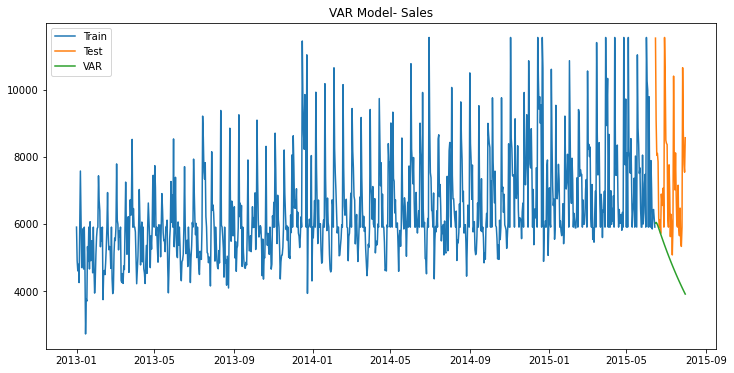

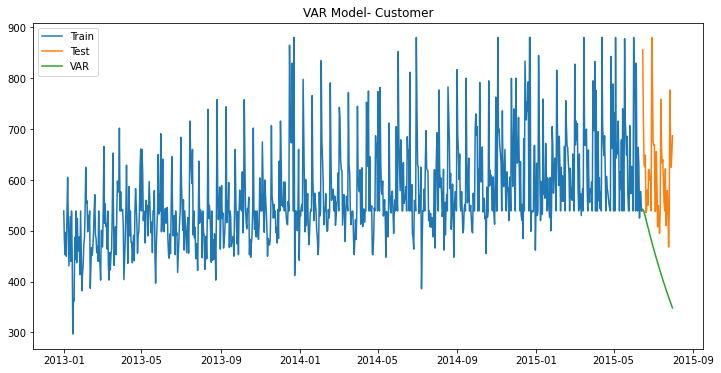

      Method   Variable     RMSE   MAPE
0  VAR_Model      Sales  2852.04  29.17
1  VAR_Model  Customers   200.18  27.15


In [89]:
s9_VAR = VAR(df9_train,df9_test)

C:\Users\acer\anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'


                             Statespace Model Results                             
Dep. Variable:     ['Sales', 'Customers']   No. Observations:                  895
Model:                        VARMAX(1,1)   Log Likelihood              -11834.780
Date:                    Mon, 31 May 2021   AIC                          23711.559
Time:                            03:31:44   BIC                          23812.293
Sample:                        01-01-2013   HQIC                         23750.050
                             - 06-14-2015                                         
Covariance Type:                      opg                                         
Ljung-Box (L1) (Q):            10.58, 0.60   Jarque-Bera (JB):        689.81, 48.17
Prob(Q):                        0.00, 0.44   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         1.69, 1.41   Skew:                      1.40, -0.08
Prob(H) (two-sided):            0.00, 0.00   Kurtosis:                   6.27, 4.12


C:\Users\acer\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\acer\anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
C:\Users\acer\anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'


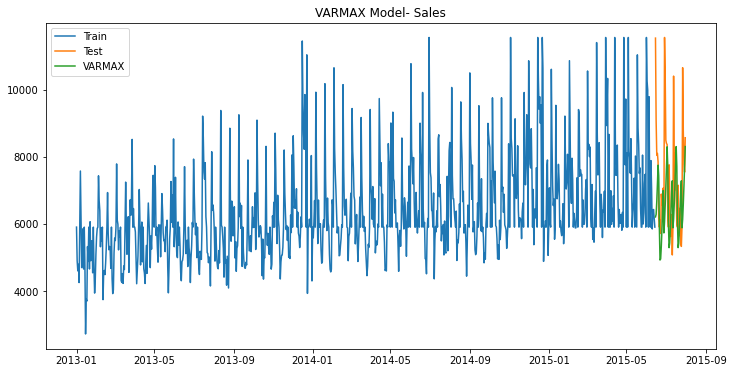

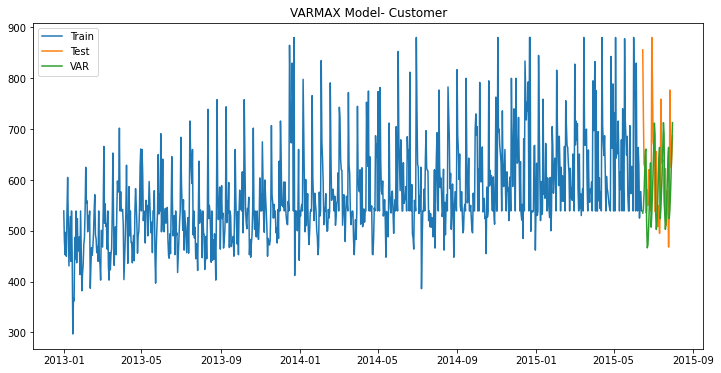

         Method   Variable     RMSE   MAPE
0  VARMAX_Model      Sales  1902.83  16.10
1  VARMAX_Model  Customers   121.15  13.61


In [90]:
exog = ['DayOfWeek','Open','Promo','StateHoliday','SchoolHoliday']
s9_VARMAX = VARMAX(df9_train,df9_test,exog)

                              ARMA Model Results                              
Dep. Variable:                  Sales   No. Observations:                  895
Model:                     ARMA(1, 1)   Log Likelihood               -7665.244
Method:                       css-mle   S.D. of innovations           1268.258
Date:                Mon, 31 May 2021   AIC                          15338.488
Time:                        03:31:49   BIC                          15357.675
Sample:                    01-01-2013   HQIC                         15345.820
                         - 06-14-2015                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const        6396.5171    107.283     59.623      0.000    6186.246    6606.788
ar.L1.Sales     0.7608      0.036     20.890      0.000       0.689       0.832
ma.L1.Sales    -0.3931      0.049     -8.060    

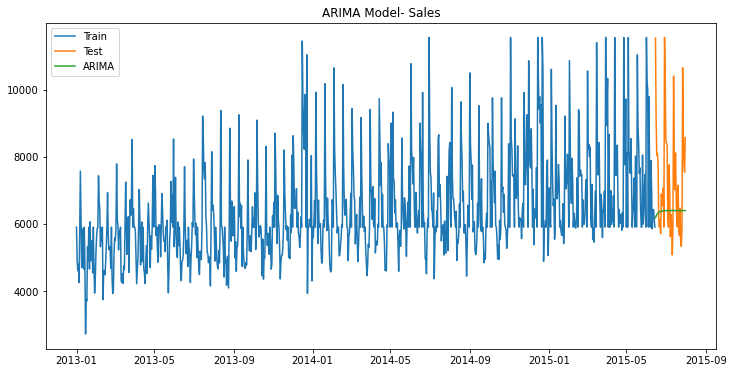

        Method Variable     RMSE   MAPE
0  ARIMA_Model    Sales  1872.97  16.18


In [91]:
s9_ARIMA = ARIMA(df9_train,df9_test)

                              ARMA Model Results                              
Dep. Variable:                  Sales   No. Observations:                  895
Model:                     ARMA(1, 1)   Log Likelihood               -7469.237
Method:                       css-mle   S.D. of innovations           1018.404
Date:                Mon, 31 May 2021   AIC                          14956.473
Time:                        03:31:50   BIC                          14999.645
Sample:                    01-01-2013   HQIC                         14972.969
                         - 06-14-2015                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const          6653.5452    326.170     20.399      0.000    6014.263    7292.827
DayOfWeek      -114.4215     21.715     -5.269      0.000    -156.982     -71.861
Open           -445.0707    115.261     

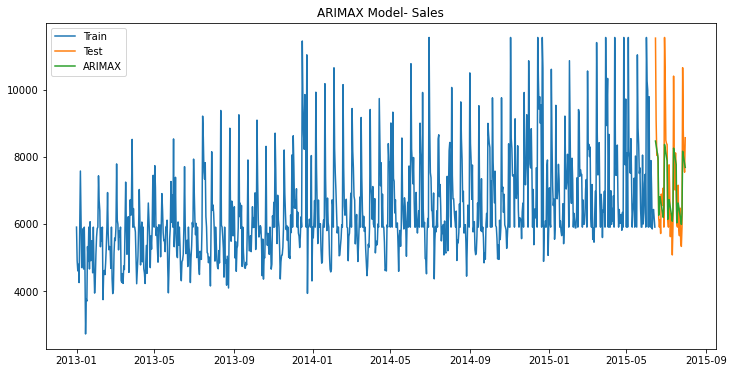

         Method Variable     RMSE  MAPE
0  ARIMAX_Model    Sales  1020.49  9.17


In [92]:
s9_ARIMAX = ARIMAX(df9_train,df9_test,exog)

                                     SARIMAX Results                                      
Dep. Variable:                              Sales   No. Observations:                  895
Model:             SARIMAX(1, 0, 1)x(1, 1, 1, 12)   Log Likelihood               -7602.596
Date:                            Mon, 31 May 2021   AIC                          15215.193
Time:                                    03:31:53   BIC                          15239.109
Sample:                                01-01-2013   HQIC                         15224.338
                                     - 06-14-2015                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8213      0.033     24.697      0.000       0.756       0.886
ma.L1         -0.4288      0.053   

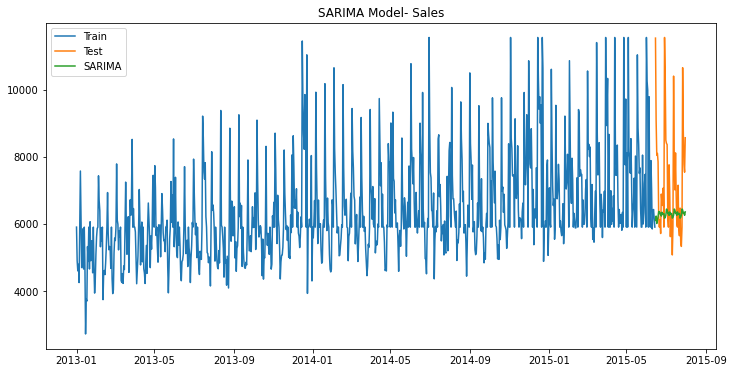

         Method Variable     RMSE   MAPE
0  SARIMA_Model    Sales  1920.94  16.22


In [93]:
s9_SARIMA = SARIMA(df9_train,df9_test)

C:\Users\acer\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                     SARIMAX Results                                      
Dep. Variable:                              Sales   No. Observations:                  895
Model:             SARIMAX(1, 0, 1)x(1, 1, 1, 12)   Log Likelihood               -7399.286
Date:                            Mon, 31 May 2021   AIC                          14818.571
Time:                                    03:32:00   BIC                          14866.405
Sample:                                01-01-2013   HQIC                         14836.861
                                     - 06-14-2015                                         
Covariance Type:                              opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
DayOfWeek      -121.9763     25.149     -4.850      0.000    -171.267     -72.686
Open           -614.2322  

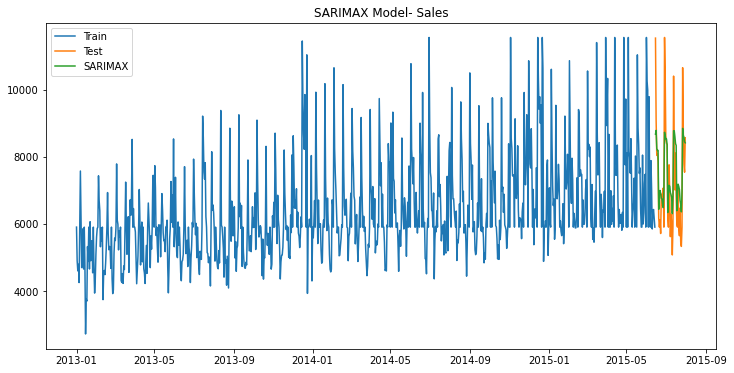

          Method Variable     RMSE  MAPE
0  SARIMAX_Model    Sales  1055.01  11.3


In [94]:
s9_SARIMAX = SARIMAX(df9_train,df9_test,exog)

In [95]:
store_9_rmses = pd.concat([s9_VAR,s9_VARMAX,s9_ARIMA,s9_ARIMAX,s9_SARIMA,s9_SARIMAX])
store_9_rmses

Method   Variable     RMSE   MAPE
0      VAR_Model      Sales  2852.04  29.17
1      VAR_Model  Customers   200.18  27.15
0   VARMAX_Model      Sales  1902.83  16.10
1   VARMAX_Model  Customers   121.15  13.61
0    ARIMA_Model      Sales  1872.97  16.18
0   ARIMAX_Model      Sales  1020.49   9.17
0   SARIMA_Model      Sales  1920.94  16.22
0  SARIMAX_Model      Sales  1055.01  11.30

**For store_9 multi variate time series(sales & Customers) VARMAX model yields good forecast and for Single time series(sales) ARIMAX is best**

# Store 13

In [96]:
#Set Date as Index and also check the date index frequency
idx = pd.date_range('2013-01-01', '2015-07-31')
store_13 = store_13.set_index('Date')
store_13 = store_13.reindex(idx, fill_value=0)
#store_13.index = pd.DatetimeIndex(store_13.index.values,freq=store_13.index.inferred_freq)

#also drop the column store as we have selected columns of a single id only
store_13.drop('Store', axis = 1 , inplace = True)

In [97]:
#Repalce any 0's in the Sales&Customers with the median value
store_13['Sales'] = np.where(store_13['Sales'] == 0,store_13['Sales'].median(),store_13['Sales'])
store_13['Customers'] = np.where(store_13['Customers'] == 0,store_13['Customers'].median(),store_13['Customers'])

In [98]:
null_value_check(store_13)

The columns that will be dropped are: []


DayOfWeek        0.0
Sales            0.0
Customers        0.0
Open             0.0
Promo            0.0
StateHoliday     0.0
SchoolHoliday    0.0
dtype: float64

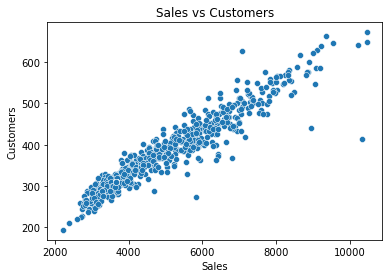

In [99]:
saleVcustomer(store_13)

- In store_13 sales and customers have a strong positive linear relationship, but as we can see there are some outliers.

Before Oulier Treatment
              Sales   Customers
count    942.000000  942.000000
mean    4563.045117  357.674098
std     1467.901911   79.640391
min     2210.000000  194.000000
25%     3650.500000  309.000000
50%     3650.750000  309.000000
75%     5427.250000  401.750000
99%     9068.950000  609.030000
100%   10460.000000  672.000000
max    10460.000000  672.000000


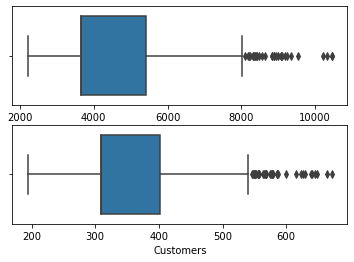

After Outlier Treatment
             Sales   Customers
count   942.000000  942.000000
mean   4556.395966  357.340021
std    1444.699470   78.490679
min    2210.000000  194.000000
25%    3650.500000  309.000000
50%    3650.750000  309.000000
75%    5427.250000  401.750000
99%    9067.740500  604.917700
100%   9068.950000  609.030000
max    9068.950000  609.030000


In [100]:
outlier_check(store_13)

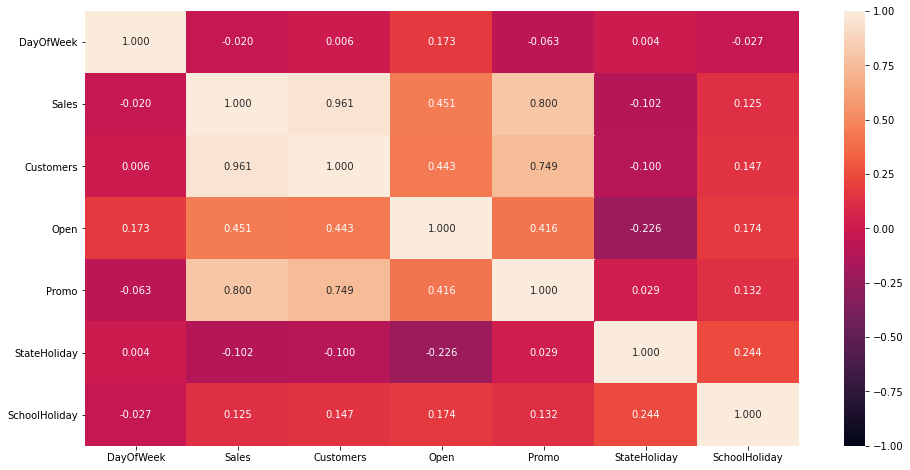

In [101]:
correlation(store_13)

In [102]:
#ADF Stationary Check
stationary_adf_test(store_13['Sales'])
stationary_adf_test(store_13['Customers'])

ADF Statistic: -3.230866
p-value: 0.018266
Critical Values @ 0.05: -2.86
ADF Statistic: -3.552080
p-value: 0.006746
Critical Values @ 0.05: -2.86


- Since both the p-values are < 0.05 we reject the null hypothesis. Sales & Customers both are stationary.

In [103]:
df13_train = store_13.loc[:train_end_date]
df13_test = store_13.loc[test_start_date:] 

                             Statespace Model Results                             
Dep. Variable:     ['Sales', 'Customers']   No. Observations:                  895
Model:                             VAR(1)   Log Likelihood              -11769.450
Date:                    Mon, 31 May 2021   AIC                          23552.901
Time:                            03:32:02   BIC                          23586.478
Sample:                        01-01-2013   HQIC                         23565.731
                             - 06-14-2015                                         
Covariance Type:                      opg                                         
Ljung-Box (L1) (Q):          62.42, 101.47   Jarque-Bera (JB):       561.94, 167.32
Prob(Q):                        0.00, 0.00   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         0.65, 0.87   Skew:                      1.19, -0.33
Prob(H) (two-sided):            0.00, 0.22   Kurtosis:                   6.06, 5.01


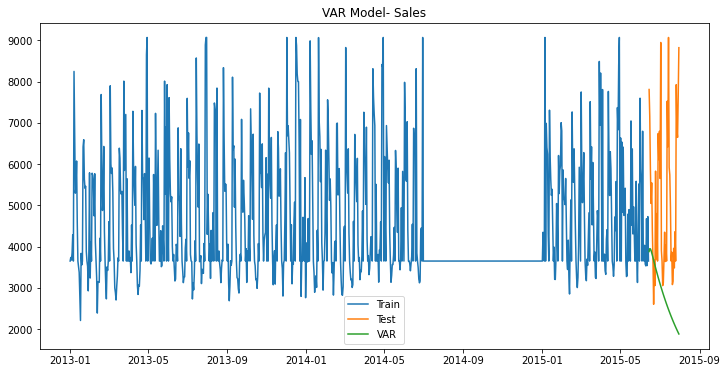

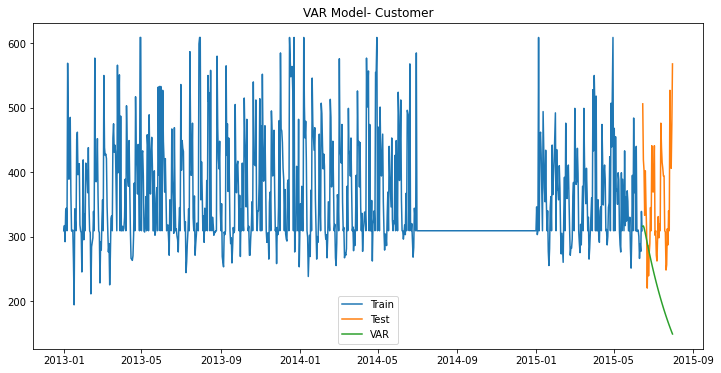

      Method   Variable     RMSE   MAPE
0  VAR_Model      Sales  2992.31  39.79
1  VAR_Model  Customers   165.09  35.04


In [105]:
s13_VAR = VAR(df13_train,df13_test)

C:\Users\acer\anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'


                             Statespace Model Results                             
Dep. Variable:     ['Sales', 'Customers']   No. Observations:                  895
Model:                        VARMAX(1,1)   Log Likelihood              -11389.471
Date:                    Mon, 31 May 2021   AIC                          22820.942
Time:                            03:32:18   BIC                          22921.675
Sample:                        01-01-2013   HQIC                         22859.433
                             - 06-14-2015                                         
Covariance Type:                      opg                                         
Ljung-Box (L1) (Q):             0.43, 0.20   Jarque-Bera (JB):       405.48, 248.97
Prob(Q):                        0.51, 0.66   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         0.63, 1.00   Skew:                      0.95, -0.41
Prob(H) (two-sided):            0.00, 0.98   Kurtosis:                   5.70, 5.45


C:\Users\acer\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\acer\anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
C:\Users\acer\anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'


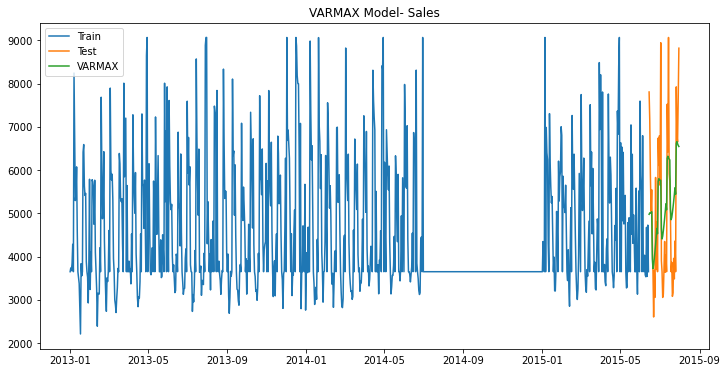

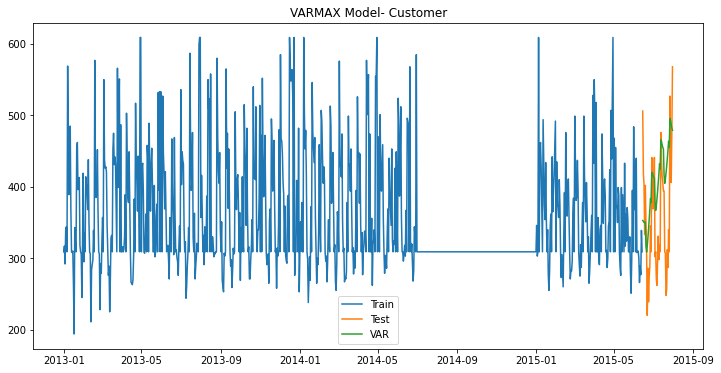

         Method   Variable     RMSE   MAPE
0  VARMAX_Model      Sales  1327.86  23.32
1  VARMAX_Model  Customers    86.90  23.33


In [106]:
exog = ['DayOfWeek','Open','Promo','StateHoliday','SchoolHoliday']
s13_VARMAX = VARMAX(df13_train,df13_test,exog)

                              ARMA Model Results                              
Dep. Variable:                  Sales   No. Observations:                  895
Model:                     ARMA(1, 1)   Log Likelihood               -7648.346
Method:                       css-mle   S.D. of innovations           1244.565
Date:                Mon, 31 May 2021   AIC                          15304.692
Time:                        03:32:23   BIC                          15323.880
Sample:                    01-01-2013   HQIC                         15312.024
                         - 06-14-2015                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const        4526.5219     94.790     47.753      0.000    4340.736    4712.307
ar.L1.Sales     0.6947      0.037     18.609      0.000       0.622       0.768
ma.L1.Sales    -0.3030      0.044     -6.940    

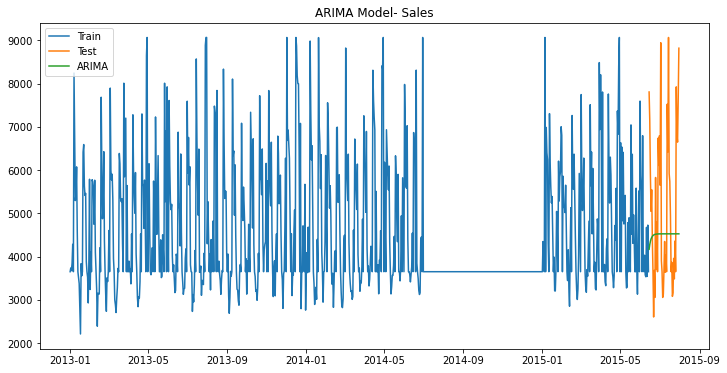

        Method Variable     RMSE   MAPE
0  ARIMA_Model    Sales  1905.72  28.56


In [107]:
s13_ARIMA = ARIMA(df13_train,df13_test)

                              ARMA Model Results                              
Dep. Variable:                  Sales   No. Observations:                  895
Model:                     ARMA(1, 1)   Log Likelihood               -7245.932
Method:                       css-mle   S.D. of innovations            793.945
Date:                Mon, 31 May 2021   AIC                          14509.864
Time:                        03:32:24   BIC                          14553.036
Sample:                    01-01-2013   HQIC                         14526.360
                         - 06-14-2015                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const          3548.6577     79.101     44.862      0.000    3393.622    3703.694
DayOfWeek       -23.6416     13.893     -1.702      0.089     -50.871       3.588
Open            636.4124     79.171     

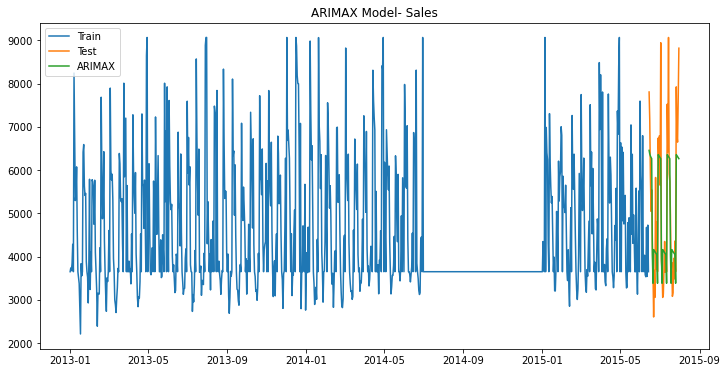

         Method Variable     RMSE   MAPE
0  ARIMAX_Model    Sales  1004.44  15.01


In [108]:
s13_ARIMAX = ARIMAX(df13_train,df13_test,exog)

C:\Users\acer\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                     SARIMAX Results                                      
Dep. Variable:                              Sales   No. Observations:                  895
Model:             SARIMAX(1, 0, 1)x(1, 1, 1, 12)   Log Likelihood               -7569.322
Date:                            Mon, 31 May 2021   AIC                          15148.644
Time:                                    03:32:27   BIC                          15172.561
Sample:                                01-01-2013   HQIC                         15157.789
                                     - 06-14-2015                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7070      0.047     14.988      0.000       0.615       0.799
ma.L1         -0.3263      0.059   

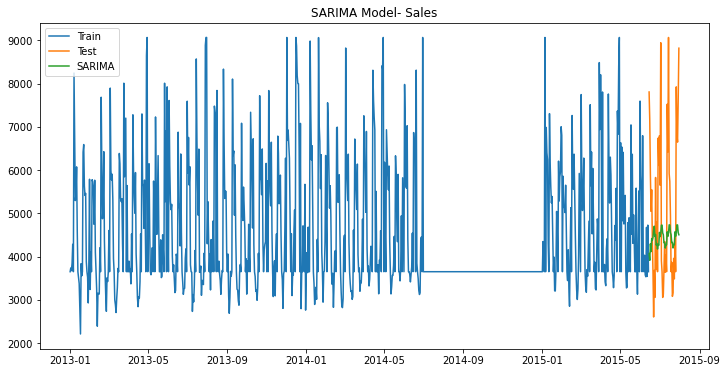

         Method Variable     RMSE   MAPE
0  SARIMA_Model    Sales  1901.78  27.38


In [109]:
s13_SARIMA = SARIMA(df13_train,df13_test)

C:\Users\acer\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                     SARIMAX Results                                      
Dep. Variable:                              Sales   No. Observations:                  895
Model:             SARIMAX(1, 0, 1)x(1, 1, 1, 12)   Log Likelihood               -7188.483
Date:                            Mon, 31 May 2021   AIC                          14396.967
Time:                                    03:32:32   BIC                          14444.800
Sample:                                01-01-2013   HQIC                         14415.256
                                     - 06-14-2015                                         
Covariance Type:                              opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
DayOfWeek       -16.4757     17.092     -0.964      0.335     -49.975      17.024
Open            380.4470  

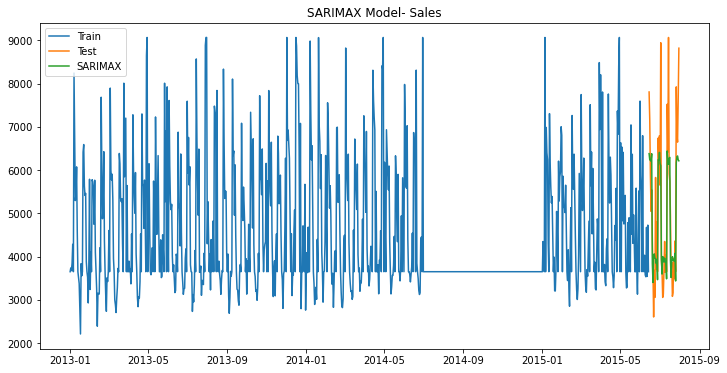

          Method Variable     RMSE   MAPE
0  SARIMAX_Model    Sales  1018.34  13.76


In [110]:
s13_SARIMAX = SARIMAX(df13_train,df13_test,exog)

In [111]:
store_13_rmses = pd.concat([s13_VAR,s13_VARMAX,s13_ARIMA,s13_ARIMAX,s13_SARIMA,s13_SARIMAX])
store_13_rmses

Method   Variable     RMSE   MAPE
0      VAR_Model      Sales  2992.31  39.79
1      VAR_Model  Customers   165.09  35.04
0   VARMAX_Model      Sales  1327.86  23.32
1   VARMAX_Model  Customers    86.90  23.33
0    ARIMA_Model      Sales  1905.72  28.56
0   ARIMAX_Model      Sales  1004.44  15.01
0   SARIMA_Model      Sales  1901.78  27.38
0  SARIMAX_Model      Sales  1018.34  13.76

**For store_13 multi variate time series(Sales & Customers) VARMAX model yield good results and for Single time Series(Sales) SARIMAX model provides good forecast**

# Store 25

In [112]:
#Set Date as Index and also check the date index frequency
store_25 = store_25.set_index('Date').sort_index()
store_25.index = pd.DatetimeIndex(store_25.index.values,freq=store_25.index.inferred_freq)

#also drop the column store as we have selected columns of a single id only
store_25.drop('Store', axis = 1 , inplace = True) 

In [113]:
#Repalce any 0's in the Sales&Customers with the median value
store_25['Sales'] = np.where(store_25['Sales'] == 0,store_25['Sales'].median(),store_25['Sales'])
store_25['Customers'] = np.where(store_25['Customers'] == 0,store_25['Customers'].median(),store_25['Customers'])

In [114]:
null_value_check(store_25)

The columns that will be dropped are: []


DayOfWeek        0.0
Sales            0.0
Customers        0.0
Open             0.0
Promo            0.0
StateHoliday     0.0
SchoolHoliday    0.0
dtype: float64

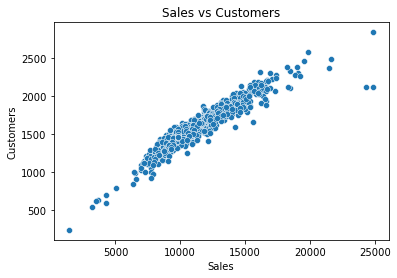

In [115]:
saleVcustomer(store_25)

Before Oulier Treatment
              Sales    Customers
count    942.000000   942.000000
mean   10890.986200  1547.154989
std     2564.596757   269.459780
min     1410.000000   237.000000
25%     9458.000000  1412.250000
50%     9810.000000  1457.250000
75%    12125.250000  1692.000000
99%    18924.800000  2299.000000
100%   24882.000000  2835.000000
max    24882.000000  2835.000000


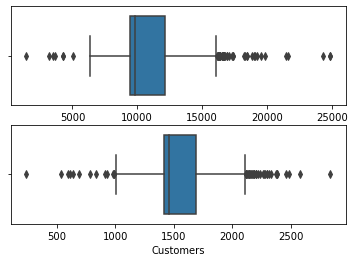

After Outlier Treatment
             Sales    Customers
count    942.00000   942.000000
mean   10864.86518  1545.645435
std     2456.48236   264.319549
min     1410.00000   237.000000
25%     9458.00000  1412.250000
50%     9810.00000  1457.250000
75%    12125.25000  1692.000000
99%    18895.77200  2299.000000
100%   18924.80000  2299.000000
max    18924.80000  2299.000000


In [116]:
outlier_check(store_25)

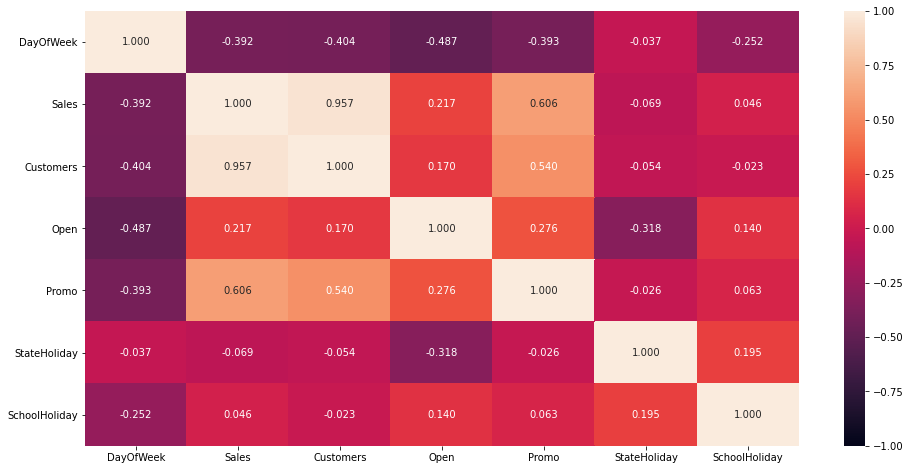

In [117]:
correlation(store_25)

In [118]:
#ADF Stationary Check
stationary_adf_test(store_25['Sales'])
stationary_adf_test(store_25['Customers'])

ADF Statistic: -5.559289
p-value: 0.000002
Critical Values @ 0.05: -2.86
ADF Statistic: -4.285188
p-value: 0.000471
Critical Values @ 0.05: -2.86


In [119]:
df25_train = store_25.loc[:train_end_date]
df25_test = store_25.loc[test_start_date:] 

                             Statespace Model Results                             
Dep. Variable:     ['Sales', 'Customers']   No. Observations:                  895
Model:                             VAR(1)   Log Likelihood              -13399.890
Date:                    Mon, 31 May 2021   AIC                          26813.779
Time:                            03:32:34   BIC                          26847.357
Sample:                        01-01-2013   HQIC                         26826.610
                             - 06-14-2015                                         
Covariance Type:                      opg                                         
Ljung-Box (L1) (Q):           22.59, 52.90   Jarque-Bera (JB):        334.58, 93.45
Prob(Q):                        0.00, 0.00   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         0.70, 1.24   Skew:                      0.91, -0.36
Prob(H) (two-sided):            0.00, 0.07   Kurtosis:                   5.37, 4.41


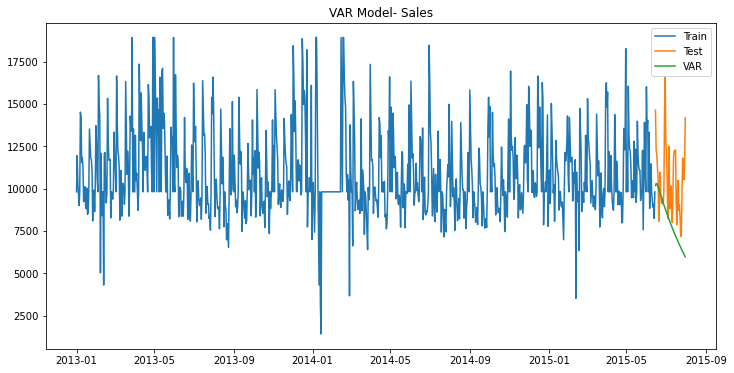

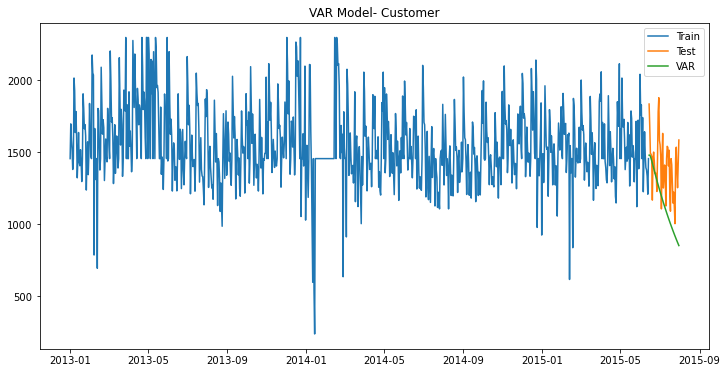

      Method   Variable     RMSE   MAPE
0  VAR_Model      Sales  3286.23  22.41
1  VAR_Model  Customers   335.87  18.84


In [120]:
s25_VAR = VAR(df25_train,df25_test)

C:\Users\acer\anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'


                             Statespace Model Results                             
Dep. Variable:     ['Sales', 'Customers']   No. Observations:                  895
Model:                        VARMAX(1,1)   Log Likelihood              -13194.920
Date:                    Mon, 31 May 2021   AIC                          26431.839
Time:                            03:33:14   BIC                          26532.573
Sample:                        01-01-2013   HQIC                         26470.330
                             - 06-14-2015                                         
Covariance Type:                      opg                                         
Ljung-Box (L1) (Q):            19.59, 5.70   Jarque-Bera (JB):         45.06, 89.54
Prob(Q):                        0.00, 0.02   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         0.83, 0.92   Skew:                      0.31, -0.41
Prob(H) (two-sided):            0.10, 0.50   Kurtosis:                   3.91, 4.32


C:\Users\acer\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\acer\anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
C:\Users\acer\anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'


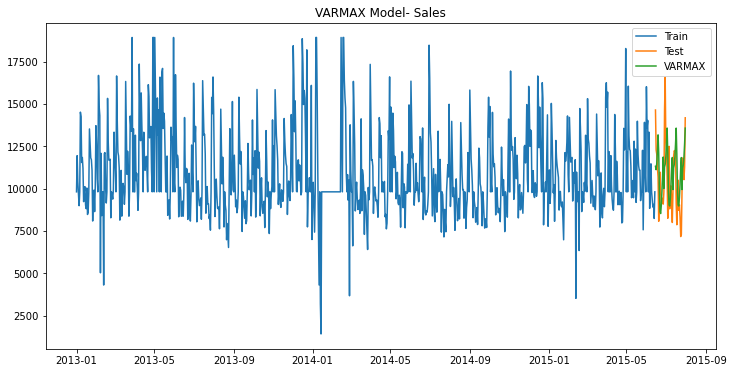

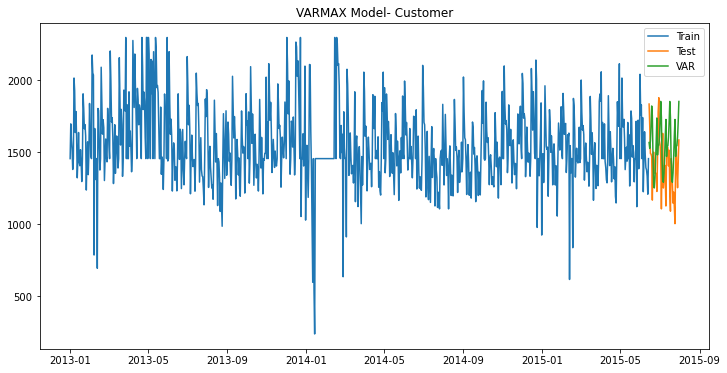

         Method   Variable     RMSE   MAPE
0  VARMAX_Model      Sales  2217.96  16.47
1  VARMAX_Model  Customers   308.09  17.78


In [121]:
exog = ['DayOfWeek','Open','Promo','StateHoliday','SchoolHoliday']
s25_VARMAX = VARMAX(df25_train,df25_test,exog)

                              ARMA Model Results                              
Dep. Variable:                  Sales   No. Observations:                  895
Model:                     ARMA(1, 1)   Log Likelihood               -8181.653
Method:                       css-mle   S.D. of innovations           2258.524
Date:                Mon, 31 May 2021   AIC                          16371.306
Time:                        03:33:19   BIC                          16390.493
Sample:                    01-01-2013   HQIC                         16378.637
                         - 06-14-2015                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const        1.088e+04    140.605     77.407      0.000    1.06e+04    1.12e+04
ar.L1.Sales     0.5776      0.072      7.988      0.000       0.436       0.719
ma.L1.Sales    -0.2123      0.088     -2.407    

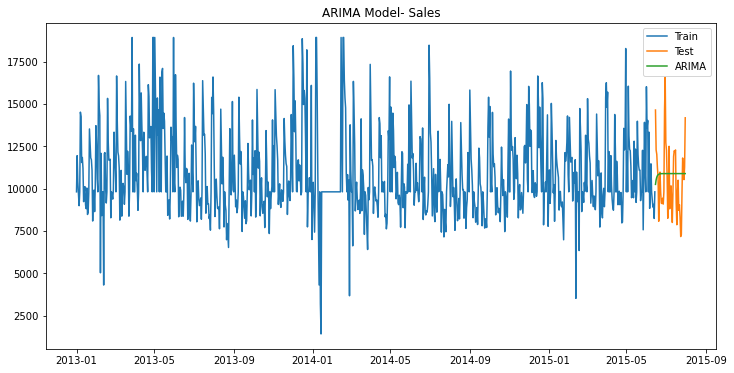

        Method Variable     RMSE   MAPE
0  ARIMA_Model    Sales  2080.73  16.99


In [122]:
s25_ARIMA = ARIMA(df25_train,df25_test)

                              ARMA Model Results                              
Dep. Variable:                  Sales   No. Observations:                  895
Model:                     ARMA(1, 1)   Log Likelihood               -7948.670
Method:                       css-mle   S.D. of innovations           1740.788
Date:                Mon, 31 May 2021   AIC                          15915.340
Time:                        03:33:20   BIC                          15958.511
Sample:                    01-01-2013   HQIC                         15931.836
                         - 06-14-2015                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const          1.147e+04    313.343     36.611      0.000    1.09e+04    1.21e+04
DayOfWeek      -287.2061     37.053     -7.751      0.000    -359.829    -214.583
Open           -555.6408    181.948     

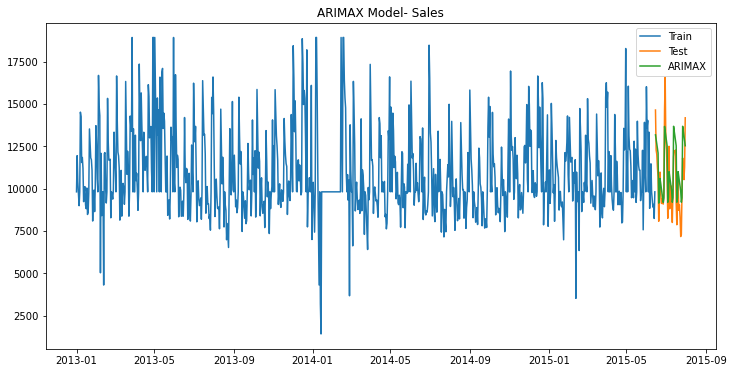

         Method Variable     RMSE   MAPE
0  ARIMAX_Model    Sales  1423.38  11.54


In [123]:
s25_ARIMAX = ARIMAX(df25_train,df25_test,exog)

C:\Users\acer\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                     SARIMAX Results                                      
Dep. Variable:                              Sales   No. Observations:                  895
Model:             SARIMAX(1, 0, 1)x(1, 1, 1, 12)   Log Likelihood               -8101.535
Date:                            Mon, 31 May 2021   AIC                          16213.069
Time:                                    03:33:23   BIC                          16236.986
Sample:                                01-01-2013   HQIC                         16222.214
                                     - 06-14-2015                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7055      0.040     17.700      0.000       0.627       0.784
ma.L1         -0.2817      0.052   

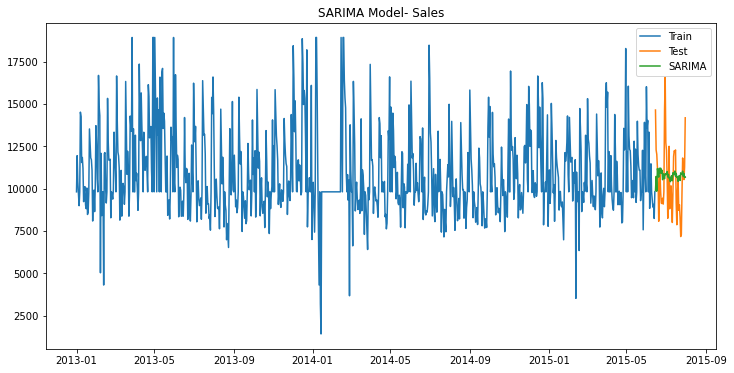

         Method Variable     RMSE   MAPE
0  SARIMA_Model    Sales  2081.73  16.61


In [124]:
s25_SARIMA = SARIMA(df25_train,df25_test)

C:\Users\acer\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                     SARIMAX Results                                      
Dep. Variable:                              Sales   No. Observations:                  895
Model:             SARIMAX(1, 0, 1)x(1, 1, 1, 12)   Log Likelihood               -7886.671
Date:                            Mon, 31 May 2021   AIC                          15793.341
Time:                                    03:33:29   BIC                          15841.175
Sample:                                01-01-2013   HQIC                         15811.631
                                     - 06-14-2015                                         
Covariance Type:                              opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
DayOfWeek      -228.9283     36.634     -6.249      0.000    -300.730    -157.127
Open           -674.8879  

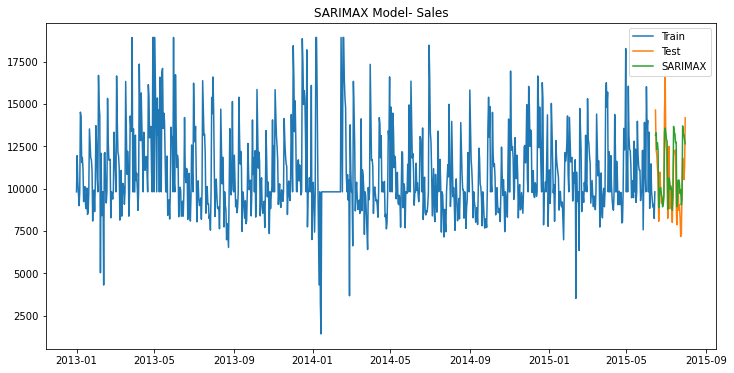

          Method Variable     RMSE   MAPE
0  SARIMAX_Model    Sales  1401.35  10.96


In [125]:
s25_SARIMAX = SARIMAX(df25_train,df25_test,exog)

In [126]:
store_25_rmses = pd.concat([s25_VAR,s25_VARMAX,s25_ARIMA,s25_ARIMAX,s25_SARIMA,s25_SARIMAX])
store_25_rmses

Method   Variable     RMSE   MAPE
0      VAR_Model      Sales  3286.23  22.41
1      VAR_Model  Customers   335.87  18.84
0   VARMAX_Model      Sales  2217.96  16.47
1   VARMAX_Model  Customers   308.09  17.78
0    ARIMA_Model      Sales  2080.73  16.99
0   ARIMAX_Model      Sales  1423.38  11.54
0   SARIMA_Model      Sales  2081.73  16.61
0  SARIMAX_Model      Sales  1401.35  10.96

**For store_25 multi variate time series(Sales & Customers) VARMAX model yield good results and for Single time Series(Sales) SARIMAX model provides good forecast**

# Store 29

In [127]:
#Set Date as Index and also check the date index frequency
store_29 = store_29.set_index('Date').sort_index()
store_29.index = pd.DatetimeIndex(store_29.index.values,freq=store_29.index.inferred_freq)

#also drop the column store as we have selected columns of a single id only
store_29.drop('Store', axis = 1 , inplace = True) 

In [128]:
#Repalce any 0's in the Sales&Customers with the median value
store_29['Sales'] = np.where(store_29['Sales'] == 0,store_29['Sales'].median(),store_29['Sales'])
store_29['Customers'] = np.where(store_29['Customers'] == 0,store_29['Customers'].median(),store_29['Customers'])

In [129]:
null_value_check(store_29)

The columns that will be dropped are: []


DayOfWeek        0.0
Sales            0.0
Customers        0.0
Open             0.0
Promo            0.0
StateHoliday     0.0
SchoolHoliday    0.0
dtype: float64

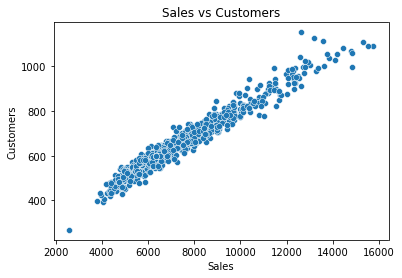

In [130]:
saleVcustomer(store_29)

- In store_29 sales and customers have a strong positive linear relationship, but as we can see there are some outliers.

Before Oulier Treatment
              Sales    Customers
count    942.000000   942.000000
mean    7191.172505   644.062633
std     2040.221826   127.095040
min     2576.000000   268.000000
25%     5994.750000   570.250000
50%     6366.250000   598.000000
75%     8072.000000   703.000000
99%    13808.260000  1054.590000
100%   15758.000000  1153.000000
max    15758.000000  1153.000000


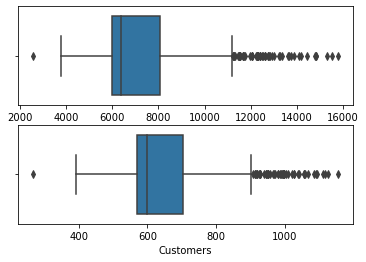

After Outlier Treatment
              Sales    Customers
count    942.000000   942.000000
mean    7181.070170   643.631529
std     2003.772081   125.585856
min     2576.000000   268.000000
25%     5994.750000   570.250000
50%     6366.250000   598.000000
75%     8072.000000   703.000000
99%    13780.683400  1054.348100
100%   13808.260000  1054.590000
max    13808.260000  1054.590000


In [131]:
outlier_check(store_29)

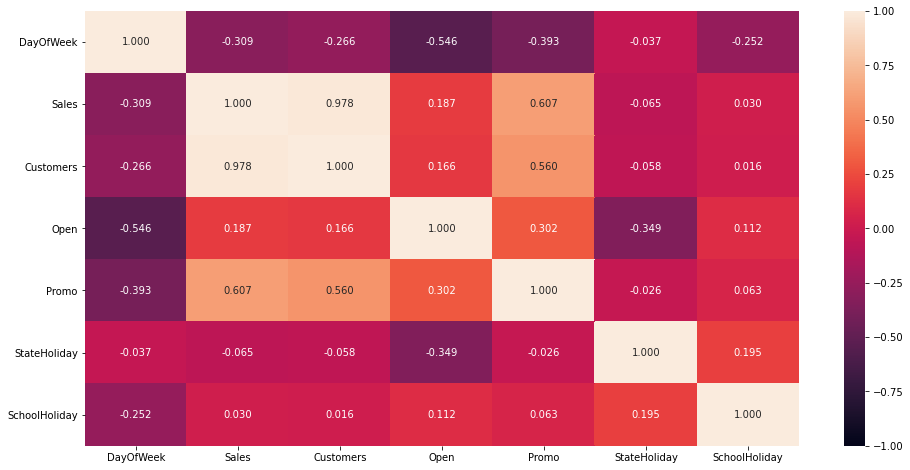

In [132]:
correlation(store_29)

In [133]:
#ADF Stationary Check
stationary_adf_test(store_29['Sales'])
stationary_adf_test(store_29['Customers'])

ADF Statistic: -3.243616
p-value: 0.017595
Critical Values @ 0.05: -2.86
ADF Statistic: -3.159497
p-value: 0.022452
Critical Values @ 0.05: -2.86


In [134]:
df29_train = store_29.loc[:train_end_date]
df29_test = store_29.loc[test_start_date:] 

                             Statespace Model Results                             
Dep. Variable:     ['Sales', 'Customers']   No. Observations:                  895
Model:                             VAR(1)   Log Likelihood              -12313.847
Date:                    Mon, 31 May 2021   AIC                          24641.695
Time:                            03:33:31   BIC                          24675.273
Sample:                        01-01-2013   HQIC                         24654.525
                             - 06-14-2015                                         
Covariance Type:                      opg                                         
Ljung-Box (L1) (Q):           42.02, 98.02   Jarque-Bera (JB):        745.36, 12.43
Prob(Q):                        0.00, 0.00   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         2.34, 1.47   Skew:                      1.51, -0.20
Prob(H) (two-sided):            0.00, 0.00   Kurtosis:                   6.29, 3.41


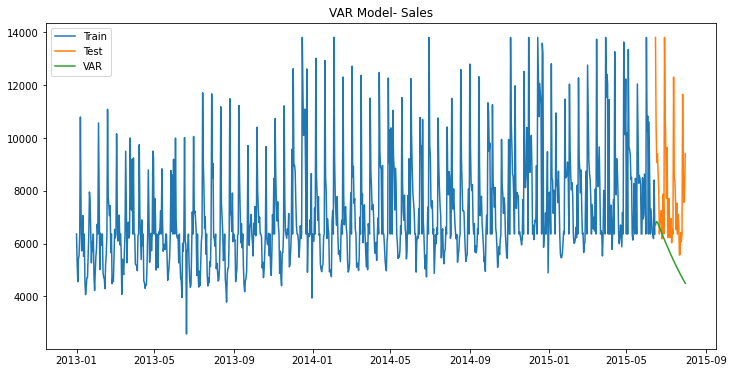

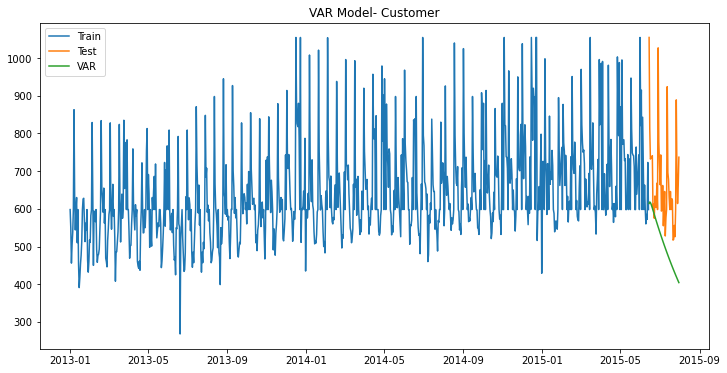

      Method   Variable     RMSE   MAPE
0  VAR_Model      Sales  2971.28  25.36
1  VAR_Model  Customers   195.75  22.13


In [135]:
s29_VAR = VAR(df29_train,df29_test)

C:\Users\acer\anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
C:\Users\acer\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                             Statespace Model Results                             
Dep. Variable:     ['Sales', 'Customers']   No. Observations:                  895
Model:                        VARMAX(1,1)   Log Likelihood              -11967.050
Date:                    Mon, 31 May 2021   AIC                          23972.101
Time:                            03:34:15   BIC                          24063.240
Sample:                        01-01-2013   HQIC                         24006.926
                             - 06-14-2015                                         
Covariance Type:                      opg                                         
Ljung-Box (L1) (Q):            55.68, 0.84   Jarque-Bera (JB):        457.55, 60.29
Prob(Q):                        0.00, 0.36   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         1.48, 1.47   Skew:                       1.27, 0.17
Prob(H) (two-sided):            0.00, 0.00   Kurtosis:                   5.42, 4.22


C:\Users\acer\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\acer\anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
C:\Users\acer\anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'


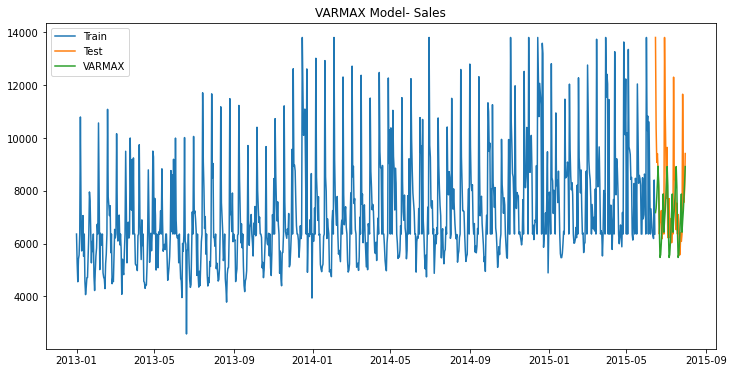

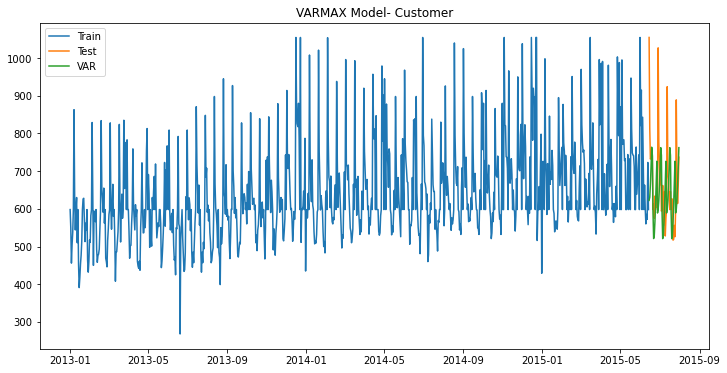

         Method   Variable     RMSE   MAPE
0  VARMAX_Model      Sales  2130.06  15.38
1  VARMAX_Model  Customers   137.00  13.17


In [136]:
exog = ['DayOfWeek','Open','Promo','StateHoliday']
s29_VARMAX = VARMAX(df29_train,df29_test,exog)

                              ARMA Model Results                              
Dep. Variable:                  Sales   No. Observations:                  895
Model:                     ARMA(1, 1)   Log Likelihood               -7960.859
Method:                       css-mle   S.D. of innovations           1764.677
Date:                Mon, 31 May 2021   AIC                          15929.717
Time:                        03:34:19   BIC                          15948.905
Sample:                    01-01-2013   HQIC                         15937.049
                         - 06-14-2015                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const        7140.6834    134.324     53.160      0.000    6877.412    7403.954
ar.L1.Sales     0.7102      0.039     18.133      0.000       0.633       0.787
ma.L1.Sales    -0.3386      0.048     -7.048    

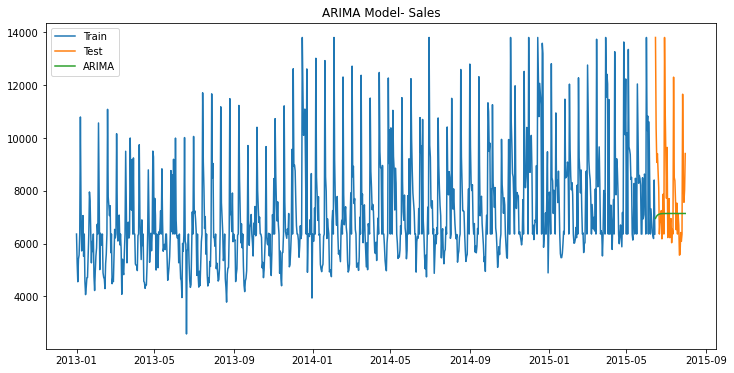

        Method Variable     RMSE  MAPE
0  ARIMA_Model    Sales  2153.56  16.3


In [137]:
s29_ARIMA = ARIMA(df29_train,df29_test)

                              ARMA Model Results                              
Dep. Variable:                  Sales   No. Observations:                  895
Model:                     ARMA(1, 1)   Log Likelihood               -7768.541
Method:                       css-mle   S.D. of innovations           1422.998
Date:                Mon, 31 May 2021   AIC                          15553.082
Time:                        03:34:21   BIC                          15591.457
Sample:                    01-01-2013   HQIC                         15567.745
                         - 06-14-2015                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const         7167.7916    385.656     18.586      0.000    6411.920    7923.663
DayOfWeek     -127.4040     29.798     -4.276      0.000    -185.807     -69.001
Open          -462.1606    161.857     -2.85

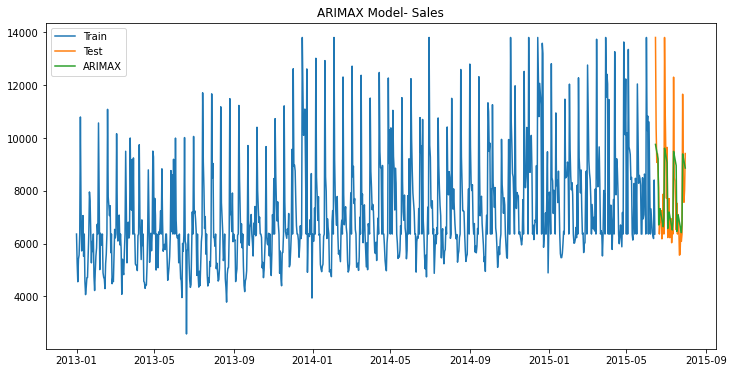

         Method Variable     RMSE  MAPE
0  ARIMAX_Model    Sales  1293.22  10.7


In [138]:
s29_ARIMAX = ARIMAX(df29_train,df29_test,exog)

                                     SARIMAX Results                                      
Dep. Variable:                              Sales   No. Observations:                  895
Model:             SARIMAX(1, 0, 1)x(1, 1, 1, 12)   Log Likelihood               -7886.569
Date:                            Mon, 31 May 2021   AIC                          15783.138
Time:                                    03:34:23   BIC                          15807.054
Sample:                                01-01-2013   HQIC                         15792.282
                                     - 06-14-2015                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6987      0.054     13.045      0.000       0.594       0.804
ma.L1         -0.3356      0.071   

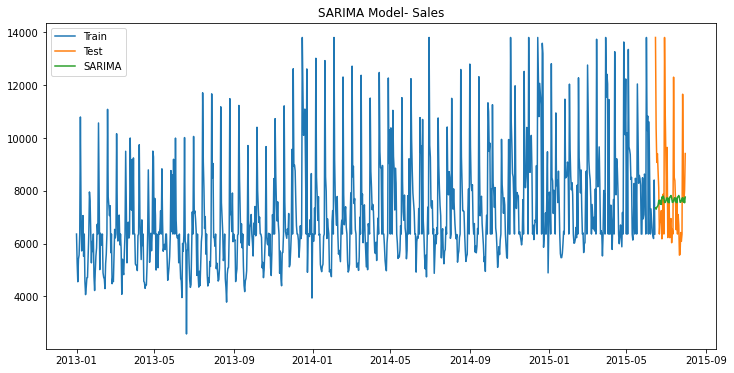

         Method Variable     RMSE   MAPE
0  SARIMA_Model    Sales  2065.01  18.05


In [139]:
s29_SARIMA = SARIMA(df29_train,df29_test)

C:\Users\acer\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                     SARIMAX Results                                      
Dep. Variable:                              Sales   No. Observations:                  895
Model:             SARIMAX(1, 0, 1)x(1, 1, 1, 12)   Log Likelihood               -7722.505
Date:                            Mon, 31 May 2021   AIC                          15463.010
Time:                                    03:34:29   BIC                          15506.060
Sample:                                01-01-2013   HQIC                         15479.470
                                     - 06-14-2015                                         
Covariance Type:                              opg                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
DayOfWeek     -207.6997   2.39e-05  -8.68e+06      0.000    -207.700    -207.700
Open          -810.2145   2.8

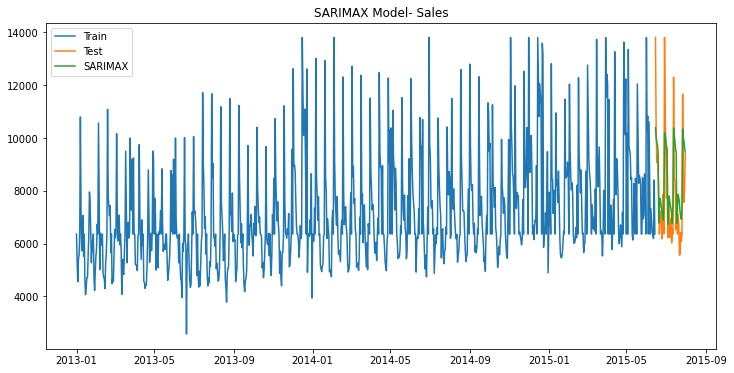

          Method Variable     RMSE   MAPE
0  SARIMAX_Model    Sales  1386.72  14.62


In [140]:
s29_SARIMAX = SARIMAX(df29_train,df29_test,exog)

In [141]:
store_29_rmses = pd.concat([s29_VAR,s29_VARMAX,s29_ARIMA,s29_ARIMAX,s29_SARIMA,s29_SARIMAX])
store_29_rmses

Method   Variable     RMSE   MAPE
0      VAR_Model      Sales  2971.28  25.36
1      VAR_Model  Customers   195.75  22.13
0   VARMAX_Model      Sales  2130.06  15.38
1   VARMAX_Model  Customers   137.00  13.17
0    ARIMA_Model      Sales  2153.56  16.30
0   ARIMAX_Model      Sales  1293.22  10.70
0   SARIMA_Model      Sales  2065.01  18.05
0  SARIMAX_Model      Sales  1386.72  14.62

**For store_29 multi variate time series(Sales & Customers) VARMAX model yield good results and for Single time Series(Sales) ARIMAX model provides good forecast**

# Store 31

In [142]:
#Set Date as Index and also check the date index frequency
store_31 = store_31.set_index('Date').sort_index()
store_31.index = pd.DatetimeIndex(store_31.index.values,freq=store_31.index.inferred_freq)

#also drop the column store as we have selected columns of a single id only
store_31.drop('Store', axis = 1 , inplace = True) 

In [143]:
#Repalce any 0's in the Sales&Customers with the median value
store_31['Sales'] = np.where(store_31['Sales'] == 0,store_31['Sales'].median(),store_31['Sales'])
store_31['Customers'] = np.where(store_31['Customers'] == 0,store_31['Customers'].median(),store_31['Customers'])

In [144]:
null_value_check(store_31)

The columns that will be dropped are: []


DayOfWeek        0.0
Sales            0.0
Customers        0.0
Open             0.0
Promo            0.0
StateHoliday     0.0
SchoolHoliday    0.0
dtype: float64

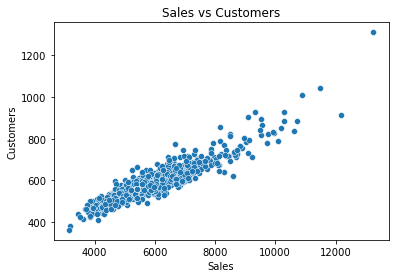

In [145]:
saleVcustomer(store_31)

Before Oulier Treatment
              Sales    Customers
count    942.000000   942.000000
mean    5785.368365   581.346072
std     1228.891666    83.387481
min     3150.000000   363.000000
25%     5065.000000   538.000000
50%     5403.000000   558.000000
75%     6316.000000   614.000000
99%    10030.550000   877.210000
100%   13252.000000  1310.000000
max    13252.000000  1310.000000


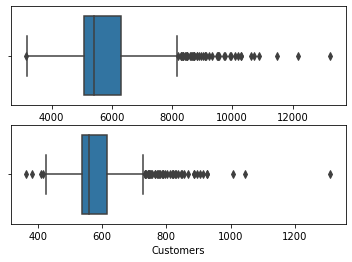

After Outlier Treatment
              Sales   Customers
count    942.000000  942.000000
mean    5775.064225  580.359979
std     1184.243640   78.189440
min     3150.000000  363.000000
25%     5065.000000  538.000000
50%     5403.000000  558.000000
75%     6316.000000  614.000000
99%     9995.474500  872.613900
100%   10030.550000  877.210000
max    10030.550000  877.210000


In [146]:
outlier_check(store_31)

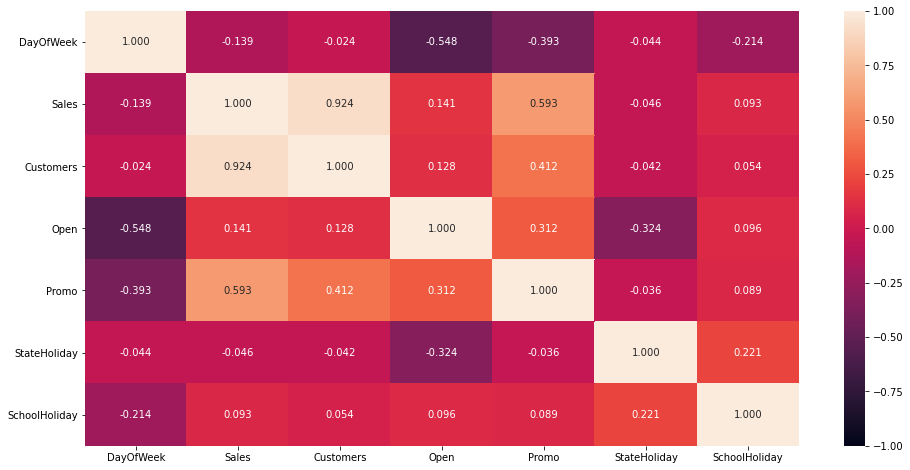

In [147]:
correlation(store_31)

In [148]:
#ADF Stationary Check
stationary_adf_test(store_31['Sales'])
stationary_adf_test(store_31['Customers'])

ADF Statistic: -5.189371
p-value: 0.000009
Critical Values @ 0.05: -2.86
ADF Statistic: -6.333524
p-value: 0.000000
Critical Values @ 0.05: -2.86


In [149]:
df31_train = store_31.loc[:train_end_date]
df31_test = store_31.loc[test_start_date:] 

                             Statespace Model Results                             
Dep. Variable:     ['Sales', 'Customers']   No. Observations:                  895
Model:                             VAR(1)   Log Likelihood              -11902.431
Date:                    Mon, 31 May 2021   AIC                          23818.862
Time:                            03:34:31   BIC                          23852.440
Sample:                        01-01-2013   HQIC                         23831.692
                             - 06-14-2015                                         
Covariance Type:                      opg                                         
Ljung-Box (L1) (Q):           96.69, 42.13   Jarque-Bera (JB):        352.10, 13.18
Prob(Q):                        0.00, 0.00   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         1.47, 0.78   Skew:                      0.34, -0.16
Prob(H) (two-sided):            0.00, 0.03   Kurtosis:                   5.99, 3.51


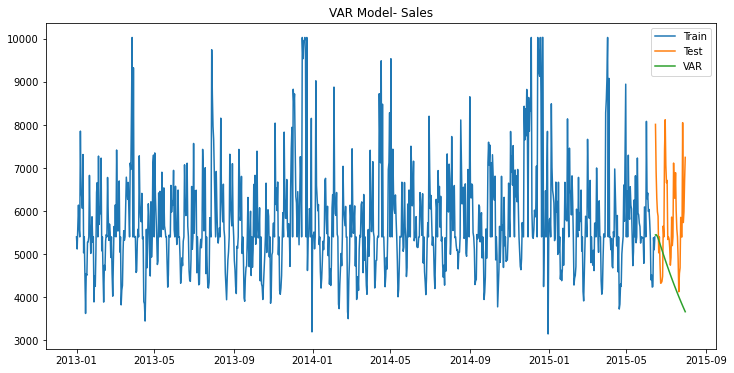

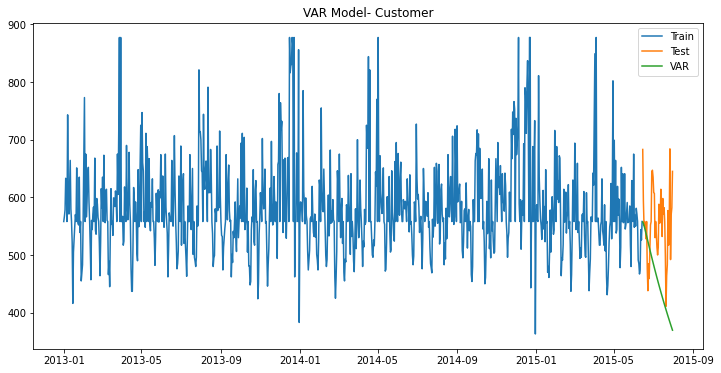

      Method   Variable     RMSE   MAPE
0  VAR_Model      Sales  1713.21  22.52
1  VAR_Model  Customers   124.58  18.11


In [150]:
s31_VAR = VAR(df31_train,df31_test)

C:\Users\acer\anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'


                             Statespace Model Results                             
Dep. Variable:     ['Sales', 'Customers']   No. Observations:                  895
Model:                        VARMAX(1,1)   Log Likelihood              -11639.119
Date:                    Mon, 31 May 2021   AIC                          23320.238
Time:                            03:35:02   BIC                          23420.971
Sample:                        01-01-2013   HQIC                         23358.729
                             - 06-14-2015                                         
Covariance Type:                      opg                                         
Ljung-Box (L1) (Q):             7.27, 0.14   Jarque-Bera (JB):        404.52, 52.12
Prob(Q):                        0.01, 0.71   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         1.43, 0.99   Skew:                      1.04, -0.01
Prob(H) (two-sided):            0.00, 0.95   Kurtosis:                   5.55, 4.18


C:\Users\acer\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\acer\anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
C:\Users\acer\anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'


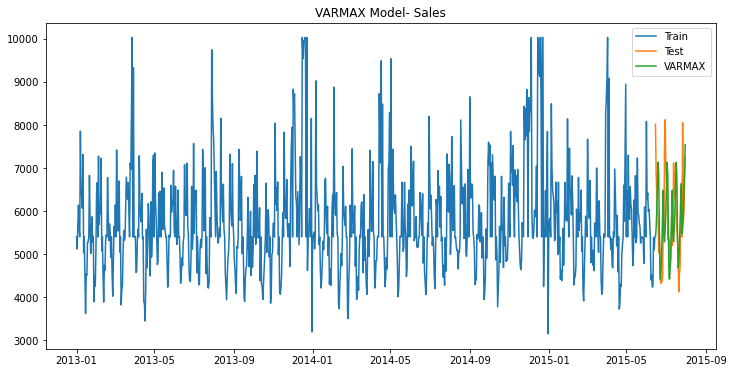

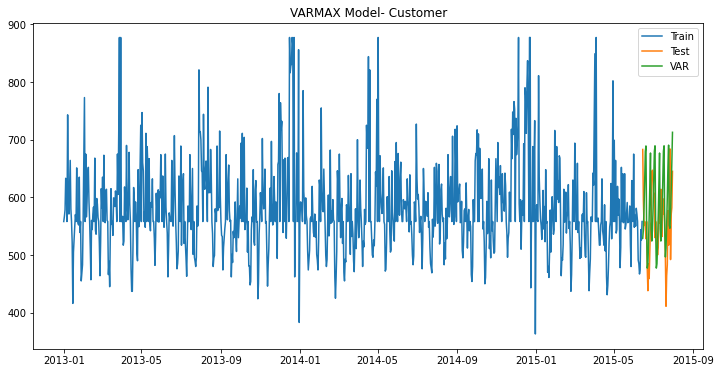

         Method   Variable     RMSE   MAPE
0  VARMAX_Model      Sales  1057.90  13.15
1  VARMAX_Model  Customers    85.45  12.83


In [151]:
exog = ['DayOfWeek','Open','Promo','StateHoliday','SchoolHoliday']
s31_VARMAX = VARMAX(df31_train,df31_test,exog)

                              ARMA Model Results                              
Dep. Variable:                  Sales   No. Observations:                  895
Model:                     ARMA(1, 1)   Log Likelihood               -7458.966
Method:                       css-mle   S.D. of innovations           1007.164
Date:                Mon, 31 May 2021   AIC                          14925.933
Time:                        03:35:07   BIC                          14945.120
Sample:                    01-01-2013   HQIC                         14933.265
                         - 06-14-2015                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const        5771.5140     90.771     63.584      0.000    5593.607    5949.421
ar.L1.Sales     0.7593      0.032     23.791      0.000       0.697       0.822
ma.L1.Sales    -0.3490      0.041     -8.583    

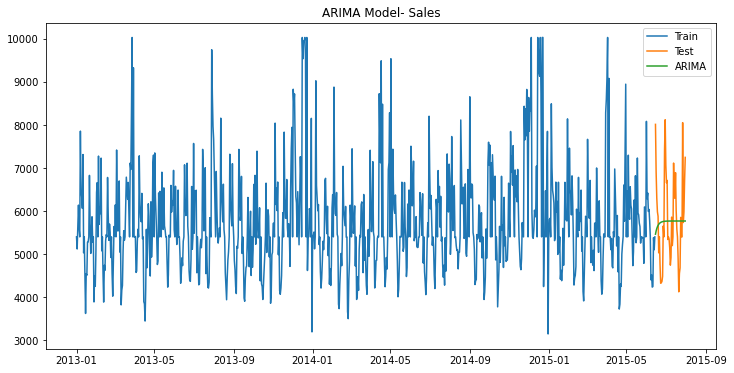

        Method Variable     RMSE   MAPE
0  ARIMA_Model    Sales  1046.28  14.68


In [152]:
s31_ARIMA = ARIMA(df31_train,df31_test)

                              ARMA Model Results                              
Dep. Variable:                  Sales   No. Observations:                  895
Model:                     ARMA(1, 1)   Log Likelihood               -7282.118
Method:                       css-mle   S.D. of innovations            826.559
Date:                Mon, 31 May 2021   AIC                          14582.237
Time:                        03:35:08   BIC                          14625.408
Sample:                    01-01-2013   HQIC                         14598.733
                         - 06-14-2015                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const          4916.7494    161.517     30.441      0.000    4600.182    5233.317
DayOfWeek        57.3739     17.689      3.244      0.001      22.705      92.043
Open             83.4120     90.865     

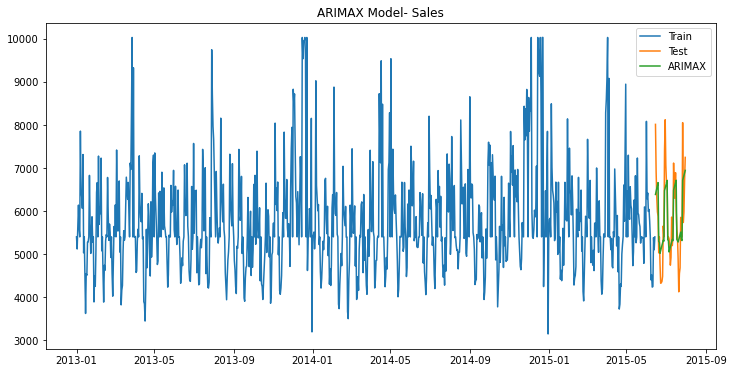

         Method Variable    RMSE  MAPE
0  ARIMAX_Model    Sales  634.94  8.46


In [153]:
s31_ARIMAX = ARIMAX(df31_train,df31_test,exog)

                                     SARIMAX Results                                      
Dep. Variable:                              Sales   No. Observations:                  895
Model:             SARIMAX(1, 0, 1)x(1, 1, 1, 12)   Log Likelihood               -7394.432
Date:                            Mon, 31 May 2021   AIC                          14798.865
Time:                                    03:35:11   BIC                          14822.781
Sample:                                01-01-2013   HQIC                         14808.009
                                     - 06-14-2015                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7933      0.023     33.764      0.000       0.747       0.839
ma.L1         -0.3582      0.040   

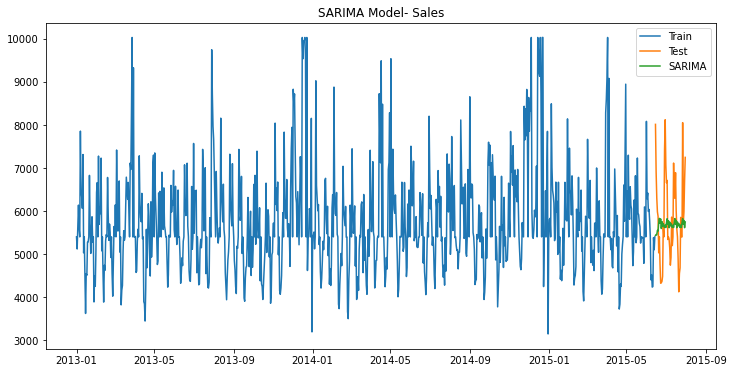

         Method Variable     RMSE   MAPE
0  SARIMA_Model    Sales  1052.72  14.42


In [154]:
s31_SARIMA = SARIMA(df31_train,df31_test)

C:\Users\acer\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                     SARIMAX Results                                      
Dep. Variable:                              Sales   No. Observations:                  895
Model:             SARIMAX(1, 0, 1)x(1, 1, 1, 12)   Log Likelihood               -7227.038
Date:                            Mon, 31 May 2021   AIC                          14474.077
Time:                                    03:35:16   BIC                          14521.910
Sample:                                01-01-2013   HQIC                         14492.366
                                     - 06-14-2015                                         
Covariance Type:                              opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
DayOfWeek        71.0961     17.878      3.977      0.000      36.056     106.137
Open            -77.3485  

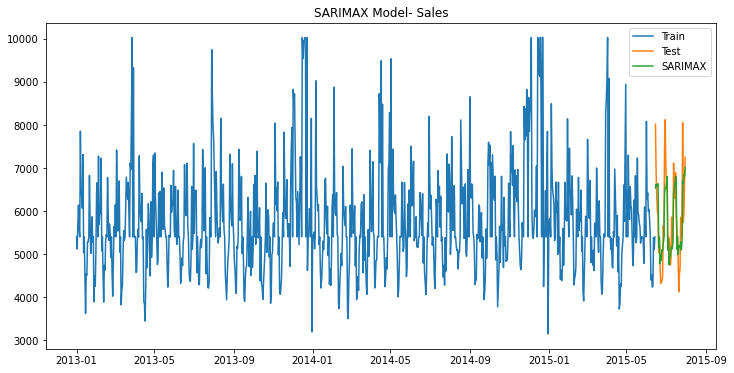

          Method Variable    RMSE  MAPE
0  SARIMAX_Model    Sales  603.11  7.83


In [155]:
s31_SARIMAX = SARIMAX(df31_train,df31_test,exog)

In [156]:
store_31_rmses = pd.concat([s31_VAR,s31_VARMAX,s31_ARIMA,s31_ARIMAX,s31_SARIMA,s31_SARIMAX])
store_31_rmses

Method   Variable     RMSE   MAPE
0      VAR_Model      Sales  1713.21  22.52
1      VAR_Model  Customers   124.58  18.11
0   VARMAX_Model      Sales  1057.90  13.15
1   VARMAX_Model  Customers    85.45  12.83
0    ARIMA_Model      Sales  1046.28  14.68
0   ARIMAX_Model      Sales   634.94   8.46
0   SARIMA_Model      Sales  1052.72  14.42
0  SARIMAX_Model      Sales   603.11   7.83

**For store_31 multi variate time series(Sales & Customers) VARMAX model yield good results and for Single time Series(Sales) SARIMAX model provides good forecast**

# Store 46

In [157]:
#Set Date as Index and also check the date index frequency
idx = pd.date_range('2013-01-01', '2015-07-31')
store_46 = store_46.set_index('Date')
store_46 = store_46.reindex(idx, fill_value=0)
#store_46.index = pd.DatetimeIndex(store_46.index.values,freq=store_46.index.inferred_freq)

#also drop the column store as we have selected columns of a single id only
store_46.drop('Store', axis = 1 , inplace = True) 

In [158]:
#Repalce any 0's in the Sales&Customers with the median value
store_46['Sales'] = np.where(store_46['Sales'] == 0,store_46['Sales'].median(),store_46['Sales'])
store_46['Customers'] = np.where(store_46['Customers'] == 0,store_46['Customers'].median(),store_46['Customers'])

In [159]:
null_value_check(store_46)

The columns that will be dropped are: []


DayOfWeek        0.0
Sales            0.0
Customers        0.0
Open             0.0
Promo            0.0
StateHoliday     0.0
SchoolHoliday    0.0
dtype: float64

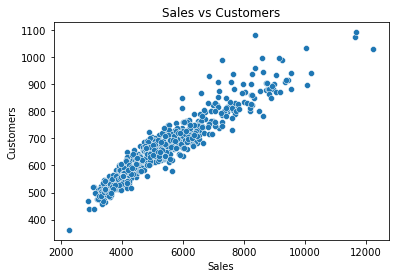

In [160]:
saleVcustomer(store_46)

Before Oulier Treatment
              Sales    Customers
count    942.000000   942.000000
mean    4907.521231   626.360934
std     1424.706774   108.236739
min     2272.000000   362.000000
25%     4043.000000   560.000000
50%     4043.000000   560.000000
75%     5612.250000   691.750000
99%     9385.110000   954.850000
100%   12250.000000  1092.000000
max    12250.000000  1092.000000


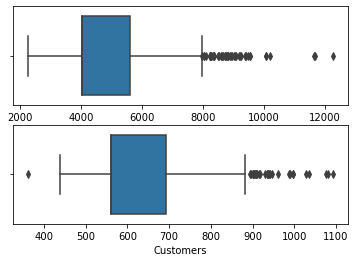

After Outlier Treatment
             Sales   Customers
count   942.000000  942.000000
mean   4896.902442  625.619427
std    1383.114305  105.618334
min    2272.000000  362.000000
25%    4043.000000  560.000000
50%    4043.000000  560.000000
75%    5612.250000  691.750000
99%    9378.094900  951.221500
100%   9385.110000  954.850000
max    9385.110000  954.850000


In [161]:
outlier_check(store_46)

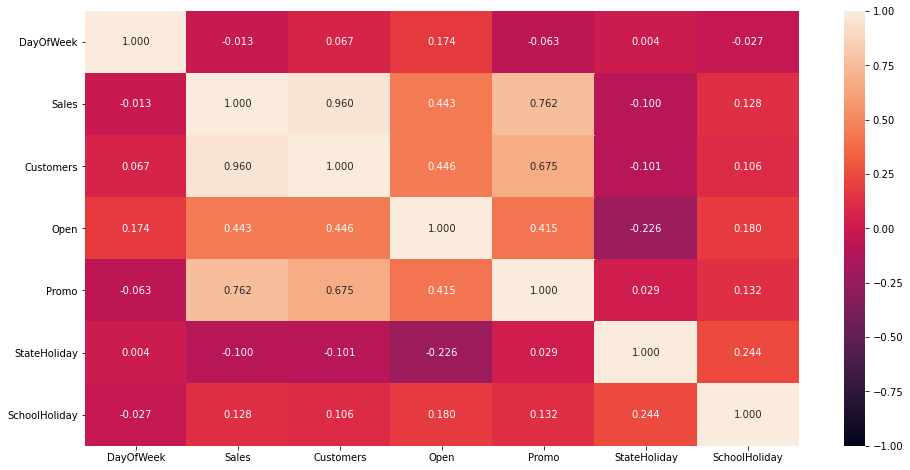

In [162]:
correlation(store_46)

In [163]:
#ADF Stationary Check
stationary_adf_test(store_46['Sales'])
stationary_adf_test(store_46['Customers'])

ADF Statistic: -3.474471
p-value: 0.008667
Critical Values @ 0.05: -2.86
ADF Statistic: -3.656361
p-value: 0.004771
Critical Values @ 0.05: -2.86


In [164]:
df46_train = store_46.loc[:train_end_date]
df46_test = store_46.loc[test_start_date:] 

                             Statespace Model Results                             
Dep. Variable:     ['Sales', 'Customers']   No. Observations:                  895
Model:                             VAR(1)   Log Likelihood              -12148.752
Date:                    Mon, 31 May 2021   AIC                          24311.504
Time:                            03:35:17   BIC                          24345.082
Sample:                        01-01-2013   HQIC                         24324.334
                             - 06-14-2015                                         
Covariance Type:                      opg                                         
Ljung-Box (L1) (Q):           69.30, 73.38   Jarque-Bera (JB):       747.72, 144.94
Prob(Q):                        0.00, 0.00   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         0.73, 0.75   Skew:                      1.45, -0.13
Prob(H) (two-sided):            0.01, 0.02   Kurtosis:                   6.40, 4.95


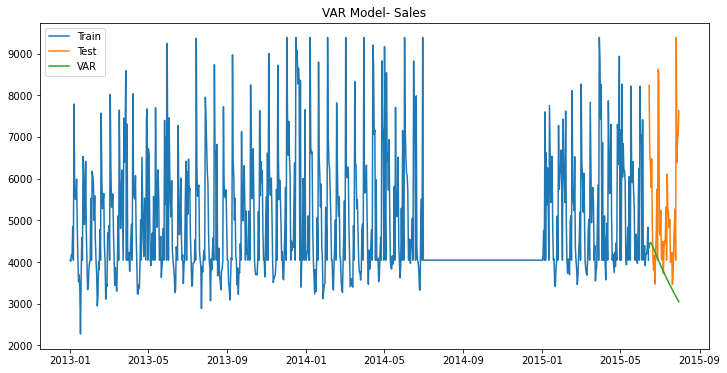

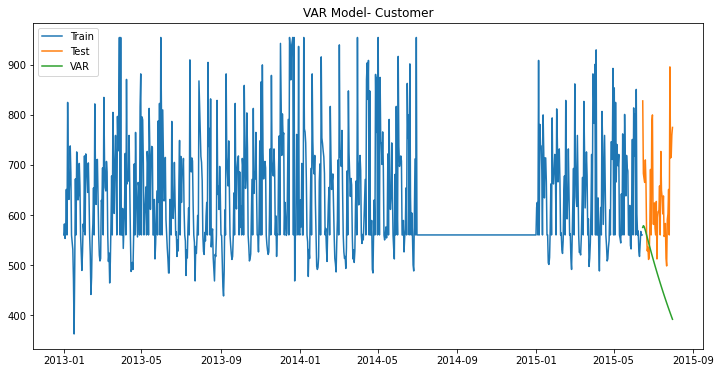

      Method   Variable     RMSE   MAPE
0  VAR_Model      Sales  2115.02  25.05
1  VAR_Model  Customers   183.45  22.43


In [165]:
s46_VAR = VAR(df46_train,df46_test)

C:\Users\acer\anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
C:\Users\acer\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                             Statespace Model Results                             
Dep. Variable:     ['Sales', 'Customers']   No. Observations:                  895
Model:                        VARMAX(1,1)   Log Likelihood              -11601.185
Date:                    Mon, 31 May 2021   AIC                          23240.370
Time:                            03:36:01   BIC                          23331.510
Sample:                        01-01-2013   HQIC                         23275.196
                             - 06-14-2015                                         
Covariance Type:                      opg                                         
Ljung-Box (L1) (Q):            38.83, 0.12   Jarque-Bera (JB):       571.64, 263.43
Prob(Q):                        0.00, 0.73   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         0.69, 0.78   Skew:                       1.38, 0.50
Prob(H) (two-sided):            0.00, 0.03   Kurtosis:                   5.77, 5.46


C:\Users\acer\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\acer\anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
C:\Users\acer\anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'


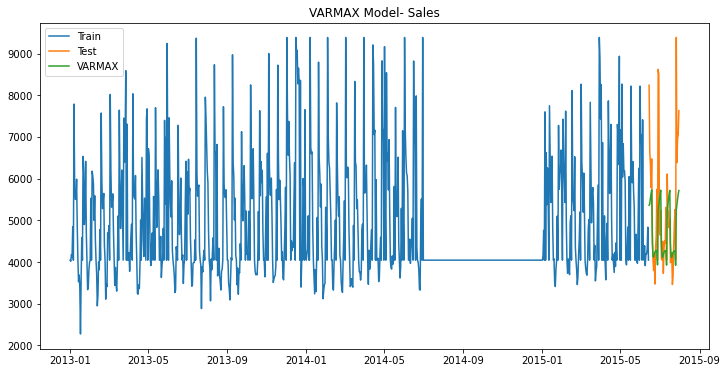

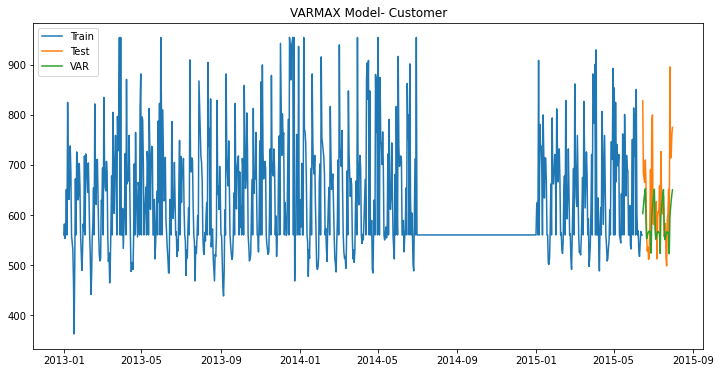

         Method   Variable     RMSE   MAPE
0  VARMAX_Model      Sales  1214.54  13.14
1  VARMAX_Model  Customers    88.60   9.61


In [166]:
exog = ['DayOfWeek','Open','Promo','StateHoliday']
s46_VARMAX = VARMAX(df46_train,df46_test,exog)

                              ARMA Model Results                              
Dep. Variable:                  Sales   No. Observations:                  895
Model:                     ARMA(1, 1)   Log Likelihood               -7632.813
Method:                       css-mle   S.D. of innovations           1223.162
Date:                Mon, 31 May 2021   AIC                          15273.625
Time:                        03:36:06   BIC                          15292.813
Sample:                    01-01-2013   HQIC                         15280.957
                         - 06-14-2015                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const        4877.3316     93.117     52.379      0.000    4694.826    5059.838
ar.L1.Sales     0.7224      0.035     20.468      0.000       0.653       0.792
ma.L1.Sales    -0.3663      0.041     -8.914    

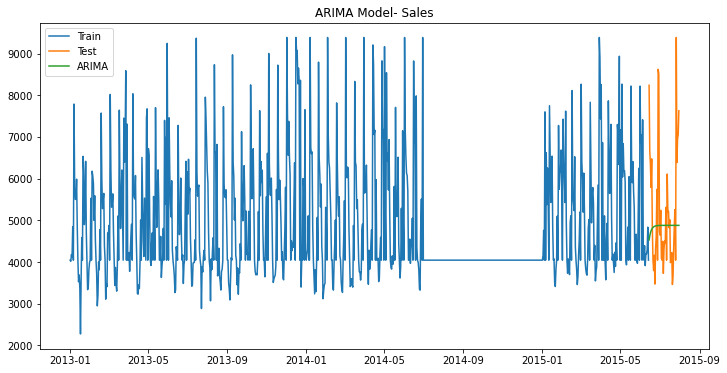

        Method Variable     RMSE   MAPE
0  ARIMA_Model    Sales  1528.36  19.63


In [167]:
s46_ARIMA = ARIMA(df46_train,df46_test)

                              ARMA Model Results                              
Dep. Variable:                  Sales   No. Observations:                  895
Model:                     ARMA(1, 1)   Log Likelihood               -7268.997
Method:                       css-mle   S.D. of innovations            814.653
Date:                Mon, 31 May 2021   AIC                          14553.994
Time:                        03:36:07   BIC                          14592.368
Sample:                    01-01-2013   HQIC                         14568.657
                         - 06-14-2015                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const         3907.0601     89.165     43.818      0.000    3732.300    4081.820
DayOfWeek      -20.8819     15.210     -1.373      0.170     -50.693       8.930
Open           726.6043     84.801      8.56

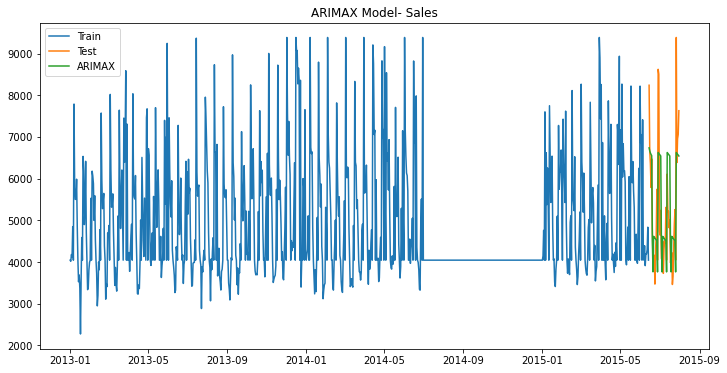

         Method Variable     RMSE   MAPE
0  ARIMAX_Model    Sales  1002.45  14.54


In [168]:
s46_ARIMAX = ARIMAX(df46_train,df46_test,exog)

                                     SARIMAX Results                                      
Dep. Variable:                              Sales   No. Observations:                  895
Model:             SARIMAX(1, 0, 1)x(1, 1, 1, 12)   Log Likelihood               -7557.176
Date:                            Mon, 31 May 2021   AIC                          15124.353
Time:                                    03:36:09   BIC                          15148.270
Sample:                                01-01-2013   HQIC                         15133.498
                                     - 06-14-2015                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7423      0.044     16.959      0.000       0.657       0.828
ma.L1         -0.3966      0.062   

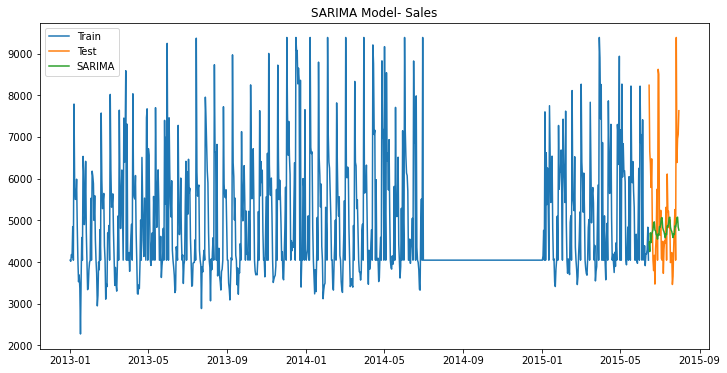

         Method Variable     RMSE   MAPE
0  SARIMA_Model    Sales  1552.32  19.01


In [169]:
s46_SARIMA = SARIMA(df46_train,df46_test)

                                     SARIMAX Results                                      
Dep. Variable:                              Sales   No. Observations:                  895
Model:             SARIMAX(1, 0, 1)x(1, 1, 1, 12)   Log Likelihood               -7222.853
Date:                            Mon, 31 May 2021   AIC                          14463.707
Time:                                    03:36:14   BIC                          14506.756
Sample:                                01-01-2013   HQIC                         14480.167
                                     - 06-14-2015                                         
Covariance Type:                              opg                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
DayOfWeek      -16.2660     17.384     -0.936      0.349     -50.338      17.806
Open           368.1501    14

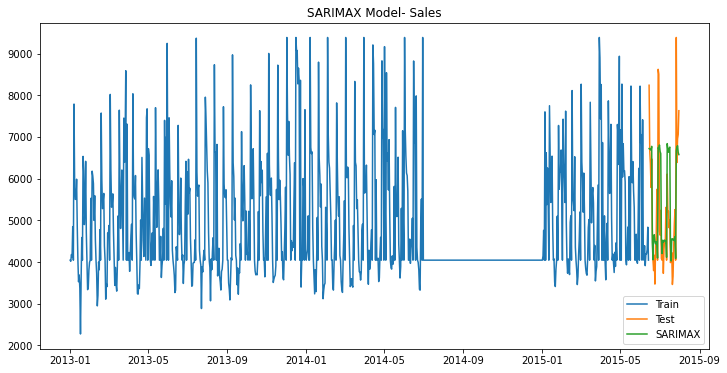

          Method Variable     RMSE   MAPE
0  SARIMAX_Model    Sales  1016.41  14.01


In [170]:
s46_SARIMAX = SARIMAX(df46_train,df46_test,exog)

In [171]:
store_46_rmses = pd.concat([s46_VAR,s46_VARMAX,s46_ARIMA,s46_ARIMAX,s46_SARIMA,s46_SARIMAX])
store_46_rmses

Method   Variable     RMSE   MAPE
0      VAR_Model      Sales  2115.02  25.05
1      VAR_Model  Customers   183.45  22.43
0   VARMAX_Model      Sales  1214.54  13.14
1   VARMAX_Model  Customers    88.60   9.61
0    ARIMA_Model      Sales  1528.36  19.63
0   ARIMAX_Model      Sales  1002.45  14.54
0   SARIMA_Model      Sales  1552.32  19.01
0  SARIMAX_Model      Sales  1016.41  14.01

**For store_46 multi variate time series(Sales & Customers) VARMAX model yield good results and for Single time Series(Sales) SARIMAX model provides good forecast**

**We have evaluated the model based on the MAPE (Mean Absolute Percentage Error) metric to choose which is best**
- MAPE is the mean or average of absolute percentage errors of the forecast.It is defined as the difference beteween
the actual value and the forecasted value. Since error terms are shown in percentages it is easy to understand and as absolute percentage errors are used, the cancelling and positive and negative errors is avoided.
- Lower the MAPE value better the forecast